In [1]:
# #load packeges
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
# Load train and Test set
train = pd.read_csv("data/housing_price_train.csv")
test = pd.read_csv("data/housing_price_test.csv")

In [3]:
# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#save sales prize
SalePrice = train['SalePrice']

In [4]:
# Now we drop the 'Id' column becouse we don't need it for the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [5]:
#  Analyzing the Test Variable (Sale Price)
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


 mu(mean) = 180921.20 and sigma(std) = 79415.29



Text(0.5, 1.0, 'SalePrice distribution')

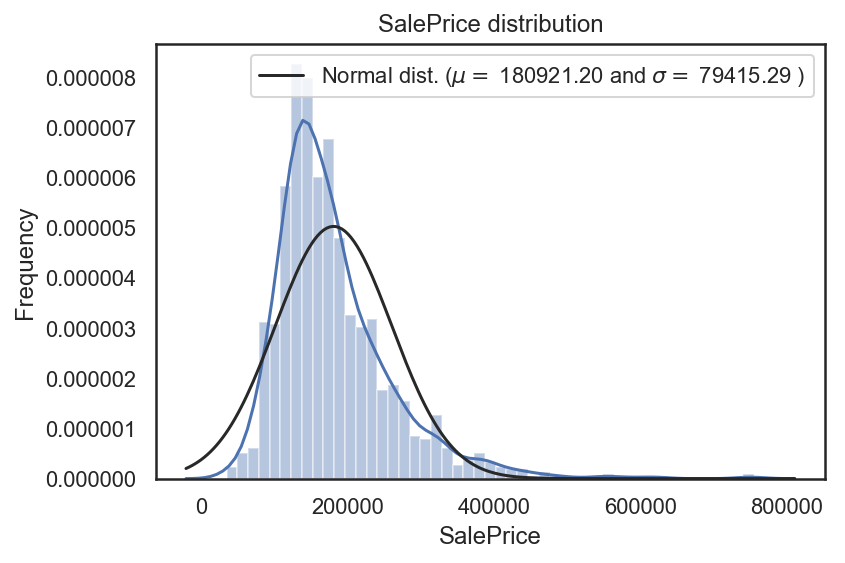

In [6]:
# Plot Histogram
sns.distplot(train['SalePrice'], fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu(mean) = {:.2f} and sigma(std) = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

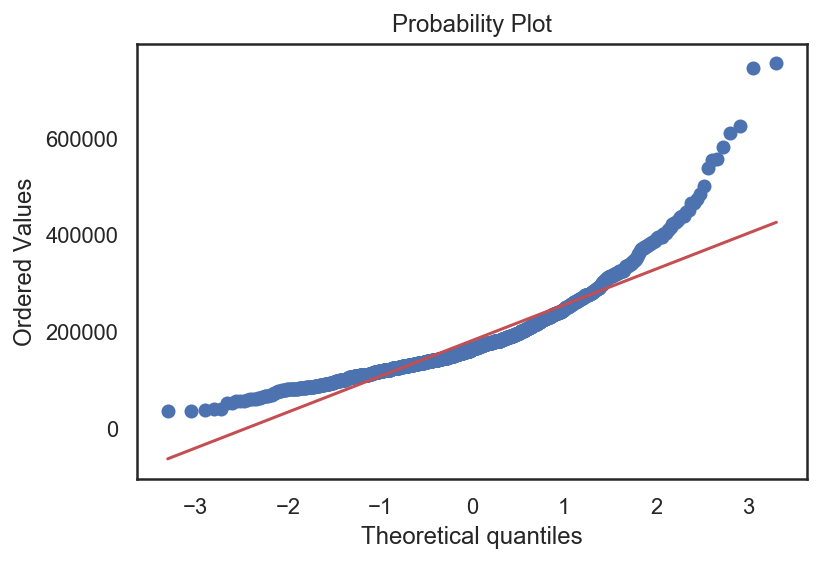

Skewness: 1.882876
Kurtosis: 6.536282


In [7]:


fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

In [8]:
#There are two types of features in housing data, categorical and numerical.

# Checking Categorical Data
train.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [9]:
# Checking Numerical Data
train.select_dtypes(include=['int64','float64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [10]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)

print('Total Features: ', cat, 'categorical', '+',num, 'numerical', '=', cat+num, 'features')

Total Features:  43 categorical + 37 numerical = 80 features


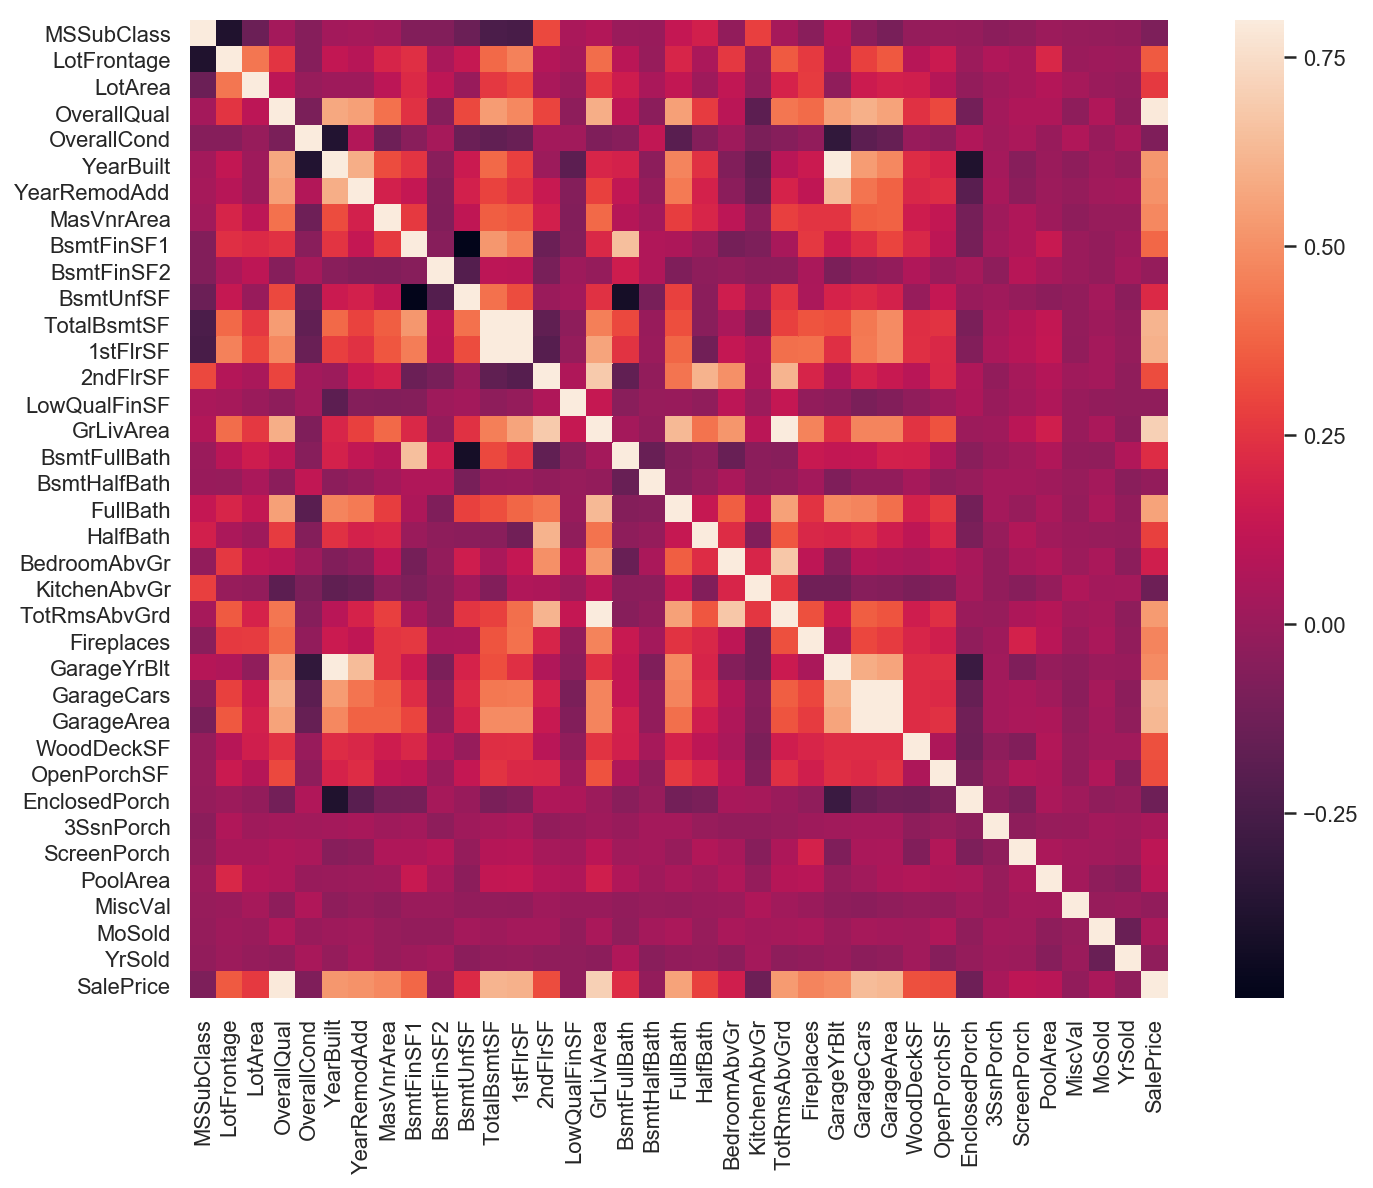

In [11]:
# Correlation Matrix Heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

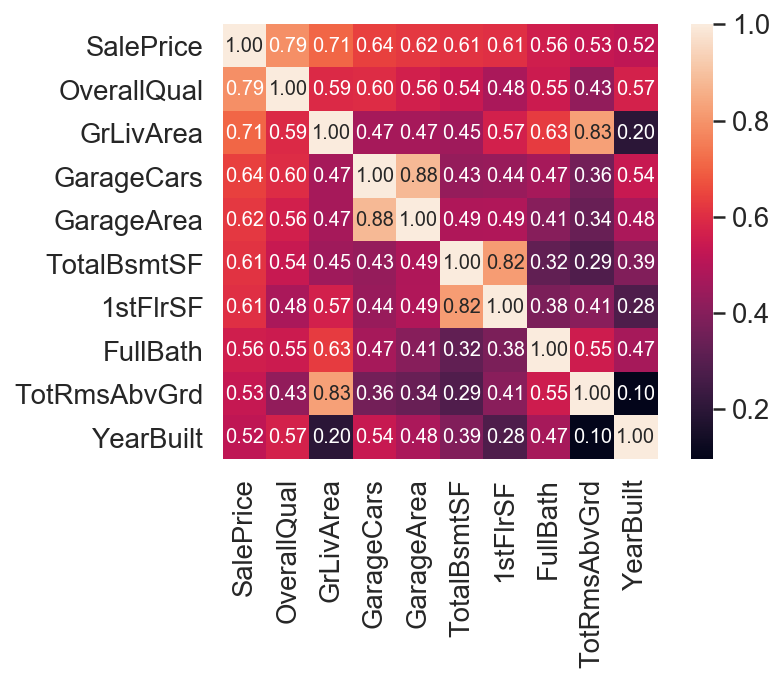

In [12]:
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [13]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,SalePrice
1,OverallQual
2,GrLivArea
3,GarageCars
4,GarageArea
5,TotalBsmtSF
6,1stFlrSF
7,FullBath
8,TotRmsAbvGrd
9,YearBuilt


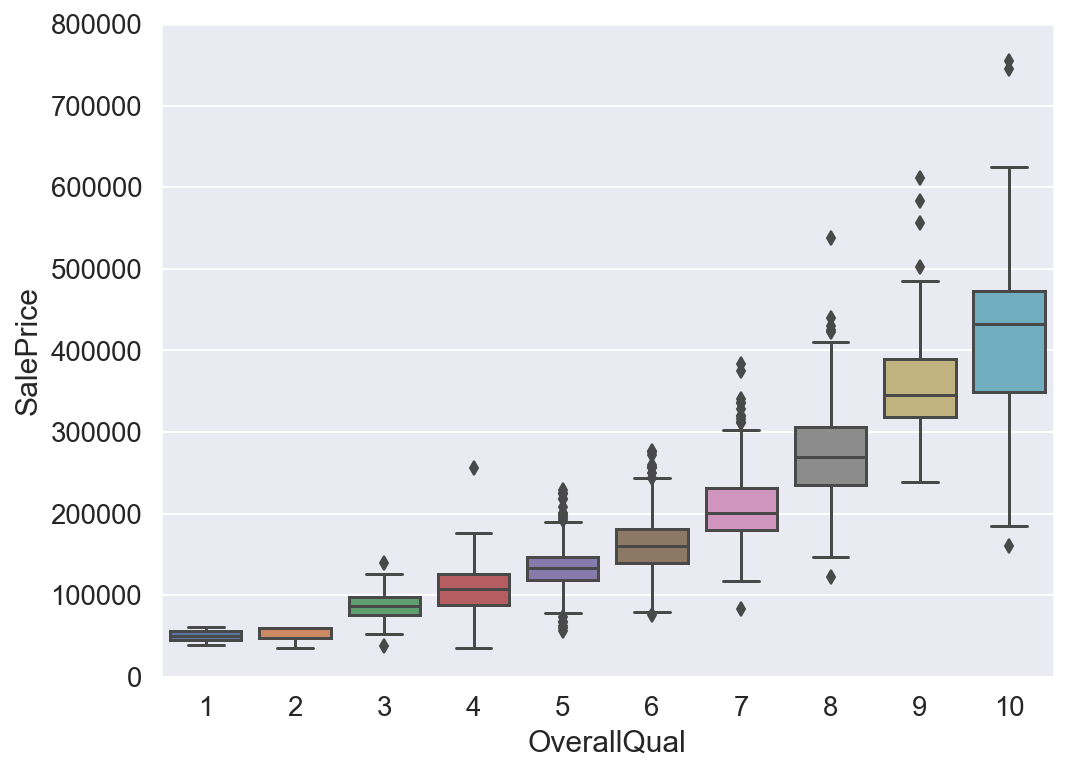

In [14]:
# Overall Quality vs Sale Price
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

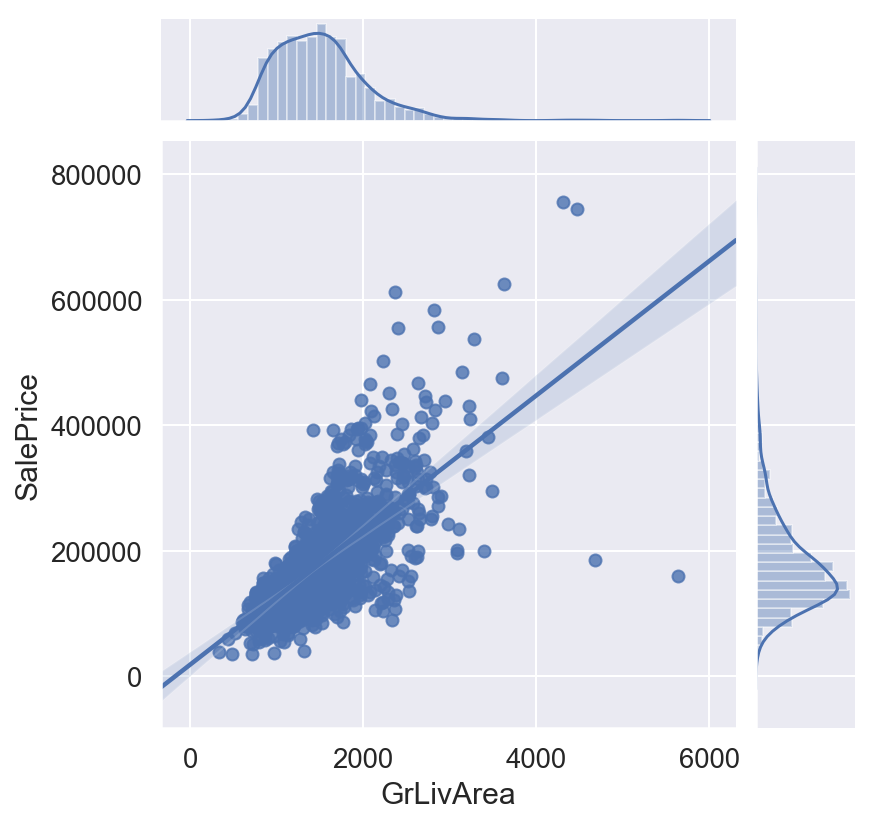

In [15]:
# Living Area vs Sale Price
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

In [16]:
# Removing outliers manually (Two points in the bottom right)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index).reset_index(drop=True)

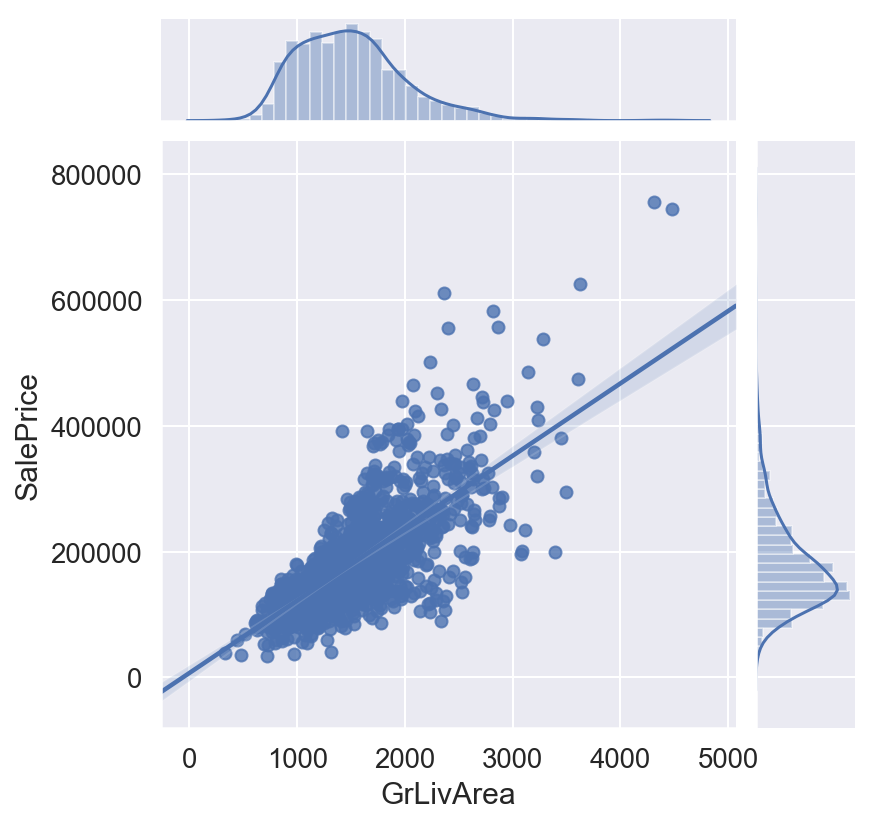

In [17]:
# Living Area vs Sale Price
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

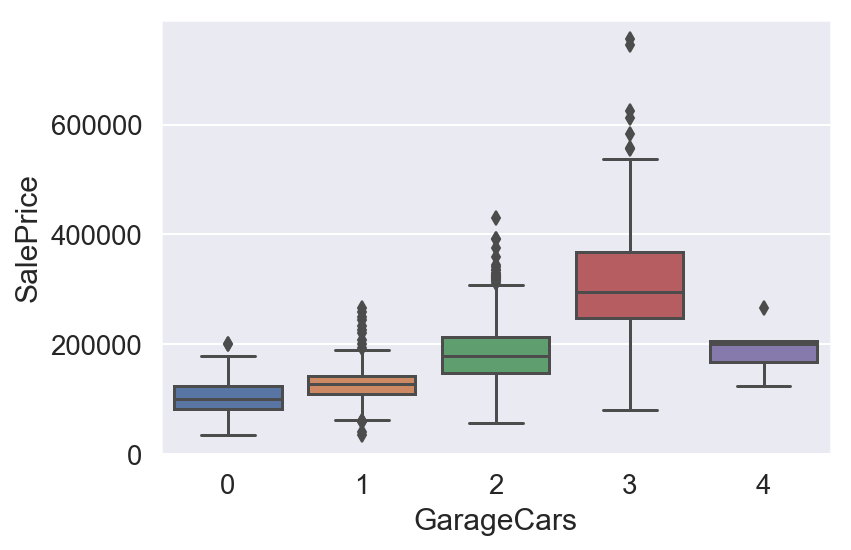

In [18]:
# Garage Area vs Sale Price
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

In [19]:
# Removing outliers manually (More than 4-cars, less than $300k)
train = train.drop(train[(train['GarageCars']>3) & (train['SalePrice']<300000)].index).reset_index(drop=True)

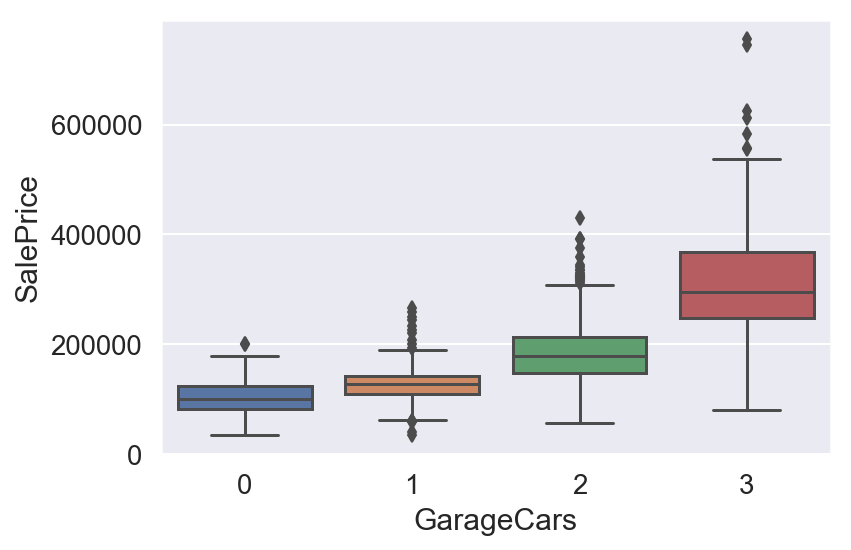

In [20]:
# Garage Area vs Sale Price
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

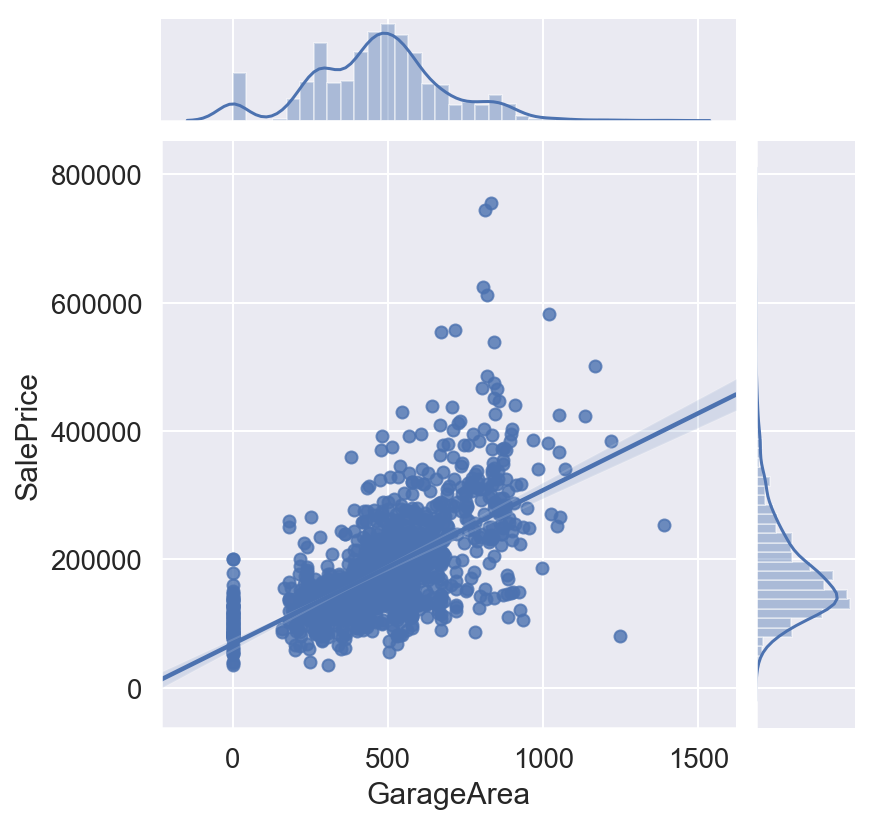

In [21]:
# Garage Area vs Sale Price
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

In [22]:
# Removing outliers manually (More than 1000 sqft, less than $300k)
train = train.drop(train[(train['GarageArea']>1000) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

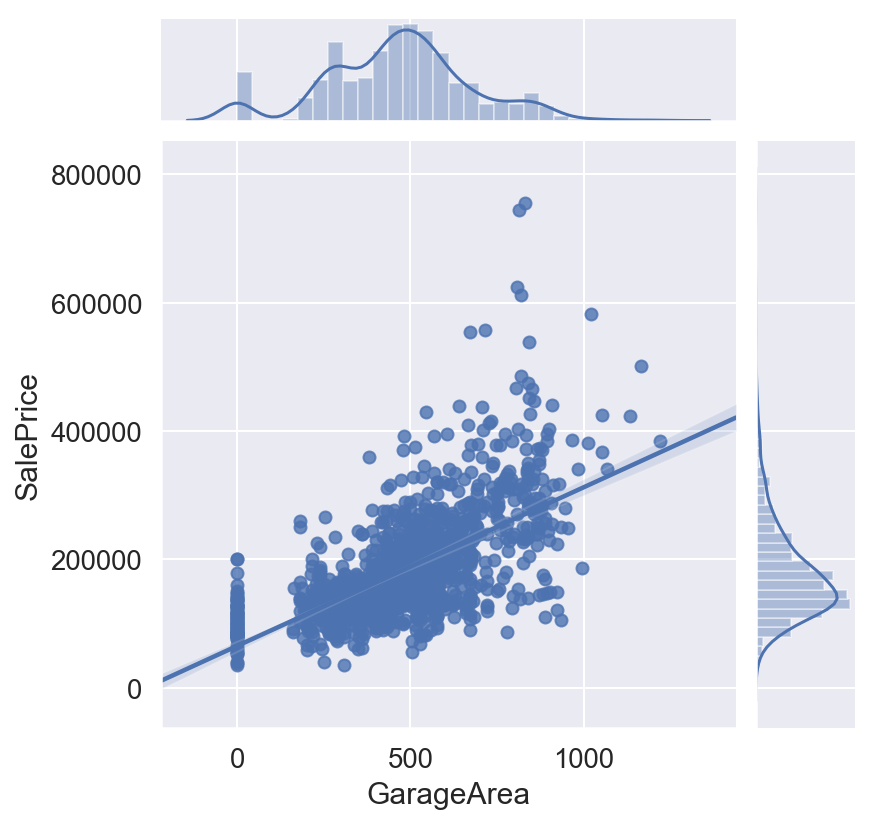

In [23]:
# Garage Area vs Sale Price
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

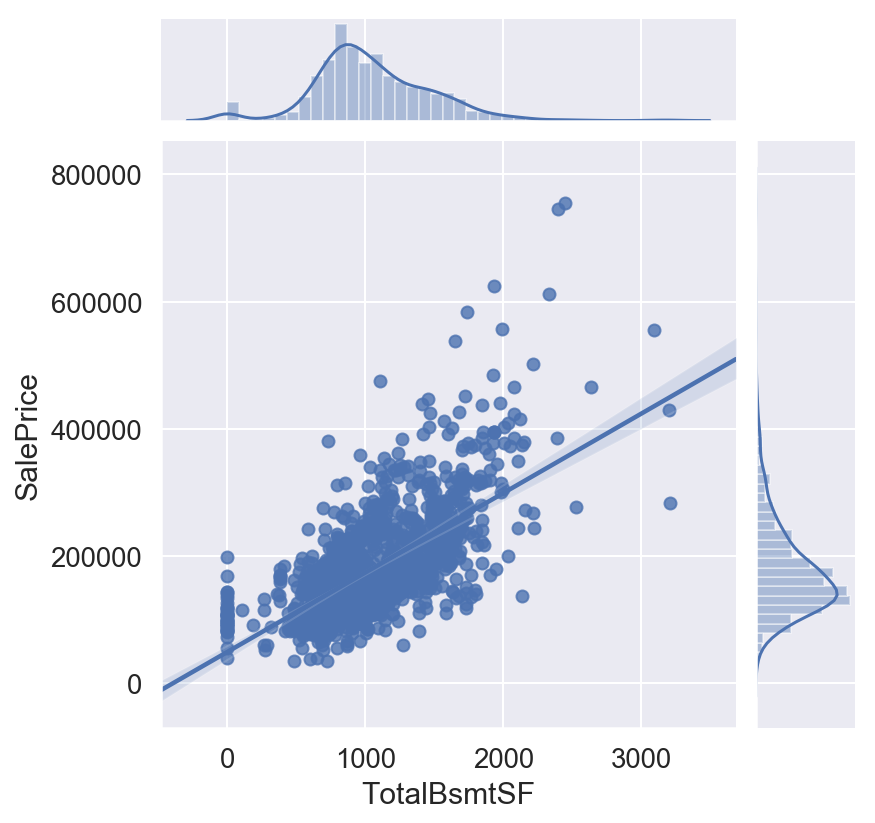

In [24]:
# Basement Area vs Sale Price
sns.jointplot(x=train['TotalBsmtSF'], y=train['SalePrice'], kind='reg')

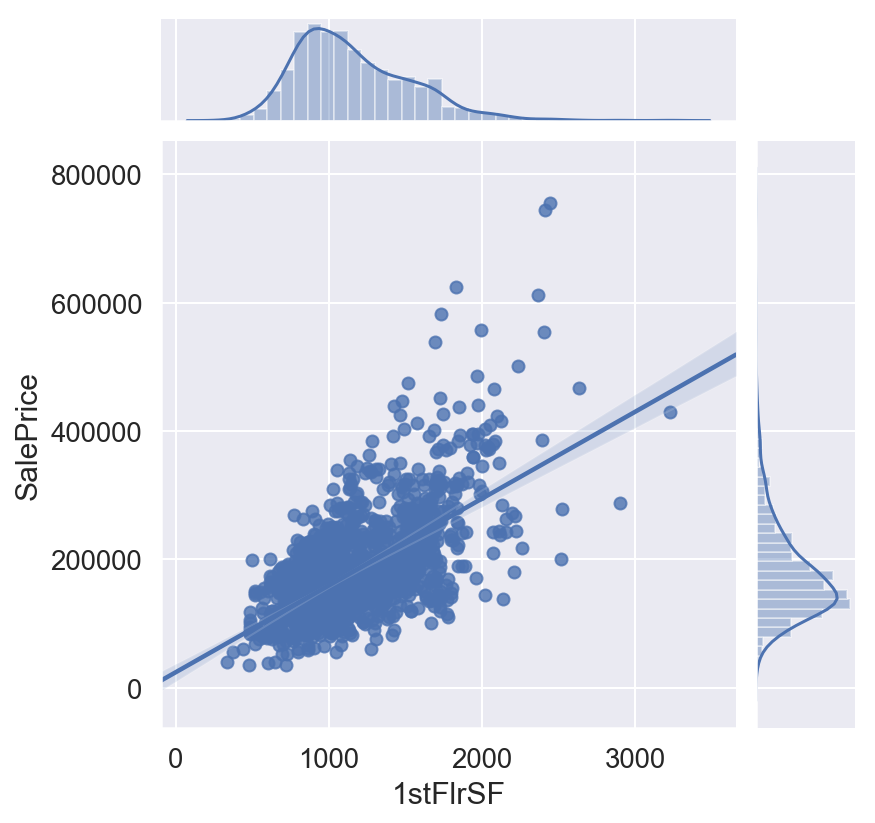

In [25]:
# First Floor Area vs Sale Price
sns.jointplot(x=train['1stFlrSF'], y=train['SalePrice'], kind='reg')

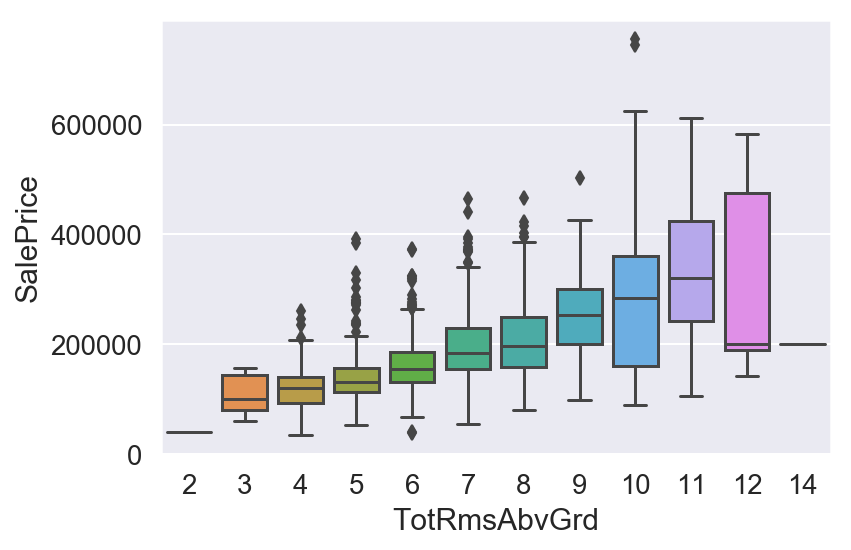

In [26]:
# Total Rooms vs Sale Price
sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'])

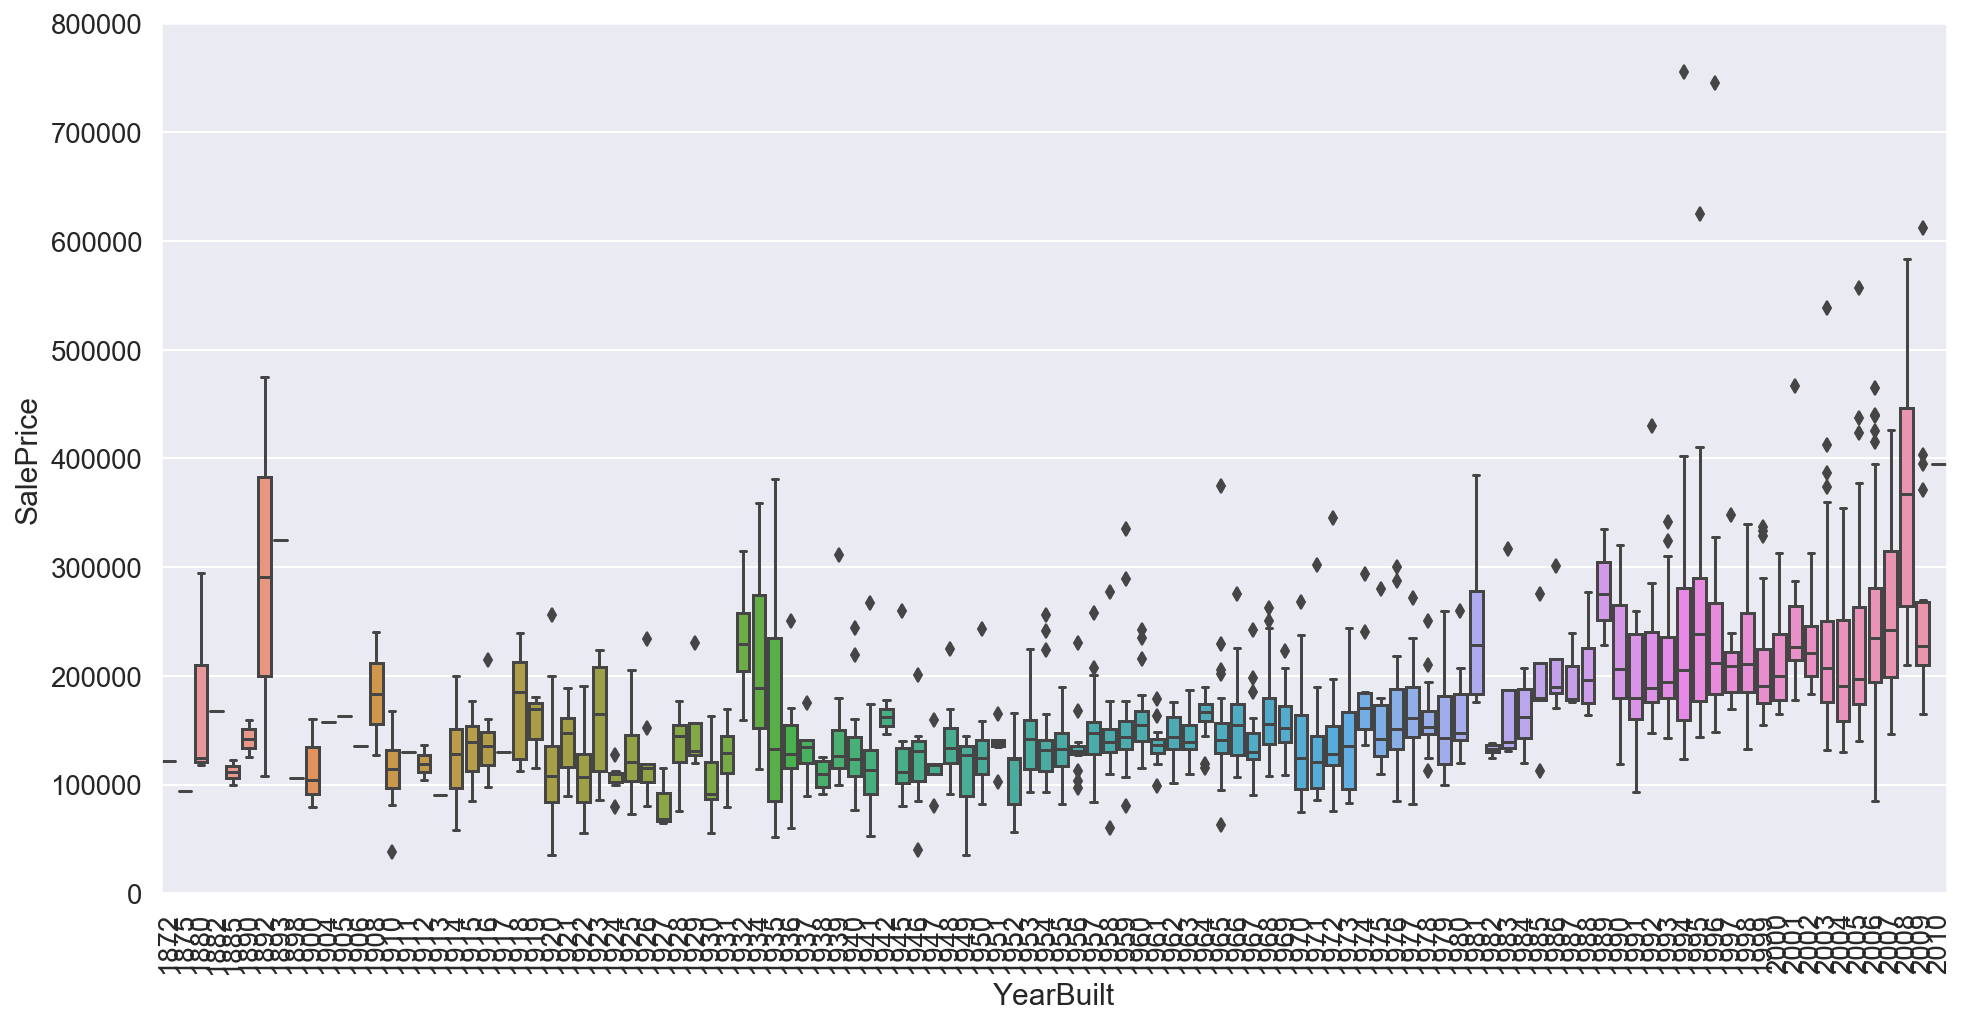

In [27]:
# YearBuild vs Sale Price
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

4. Impute Missing Data and Clean Data

In [28]:
ntrain = train.shape[0]
ntest = test.shape[0]

# Combining Datasets
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)


#drop sales price
all_data.drop(['SalePrice'], axis=1, inplace=True)  

print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (1448, 80)
Test data size is : (1560, 79)
Combined dataset size is : (3008, 79)


In [29]:
# Find Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
PoolQC,99.700798
MiscFeature,96.409574
Alley,93.118351
Fence,80.285904
FireplaceQu,48.736702
LotFrontage,16.456117
GarageQual,5.418883
GarageCond,5.418883
GarageFinish,5.418883
GarageYrBlt,5.418883


Text(0.5, 1.0, 'Percent missing data by feature')

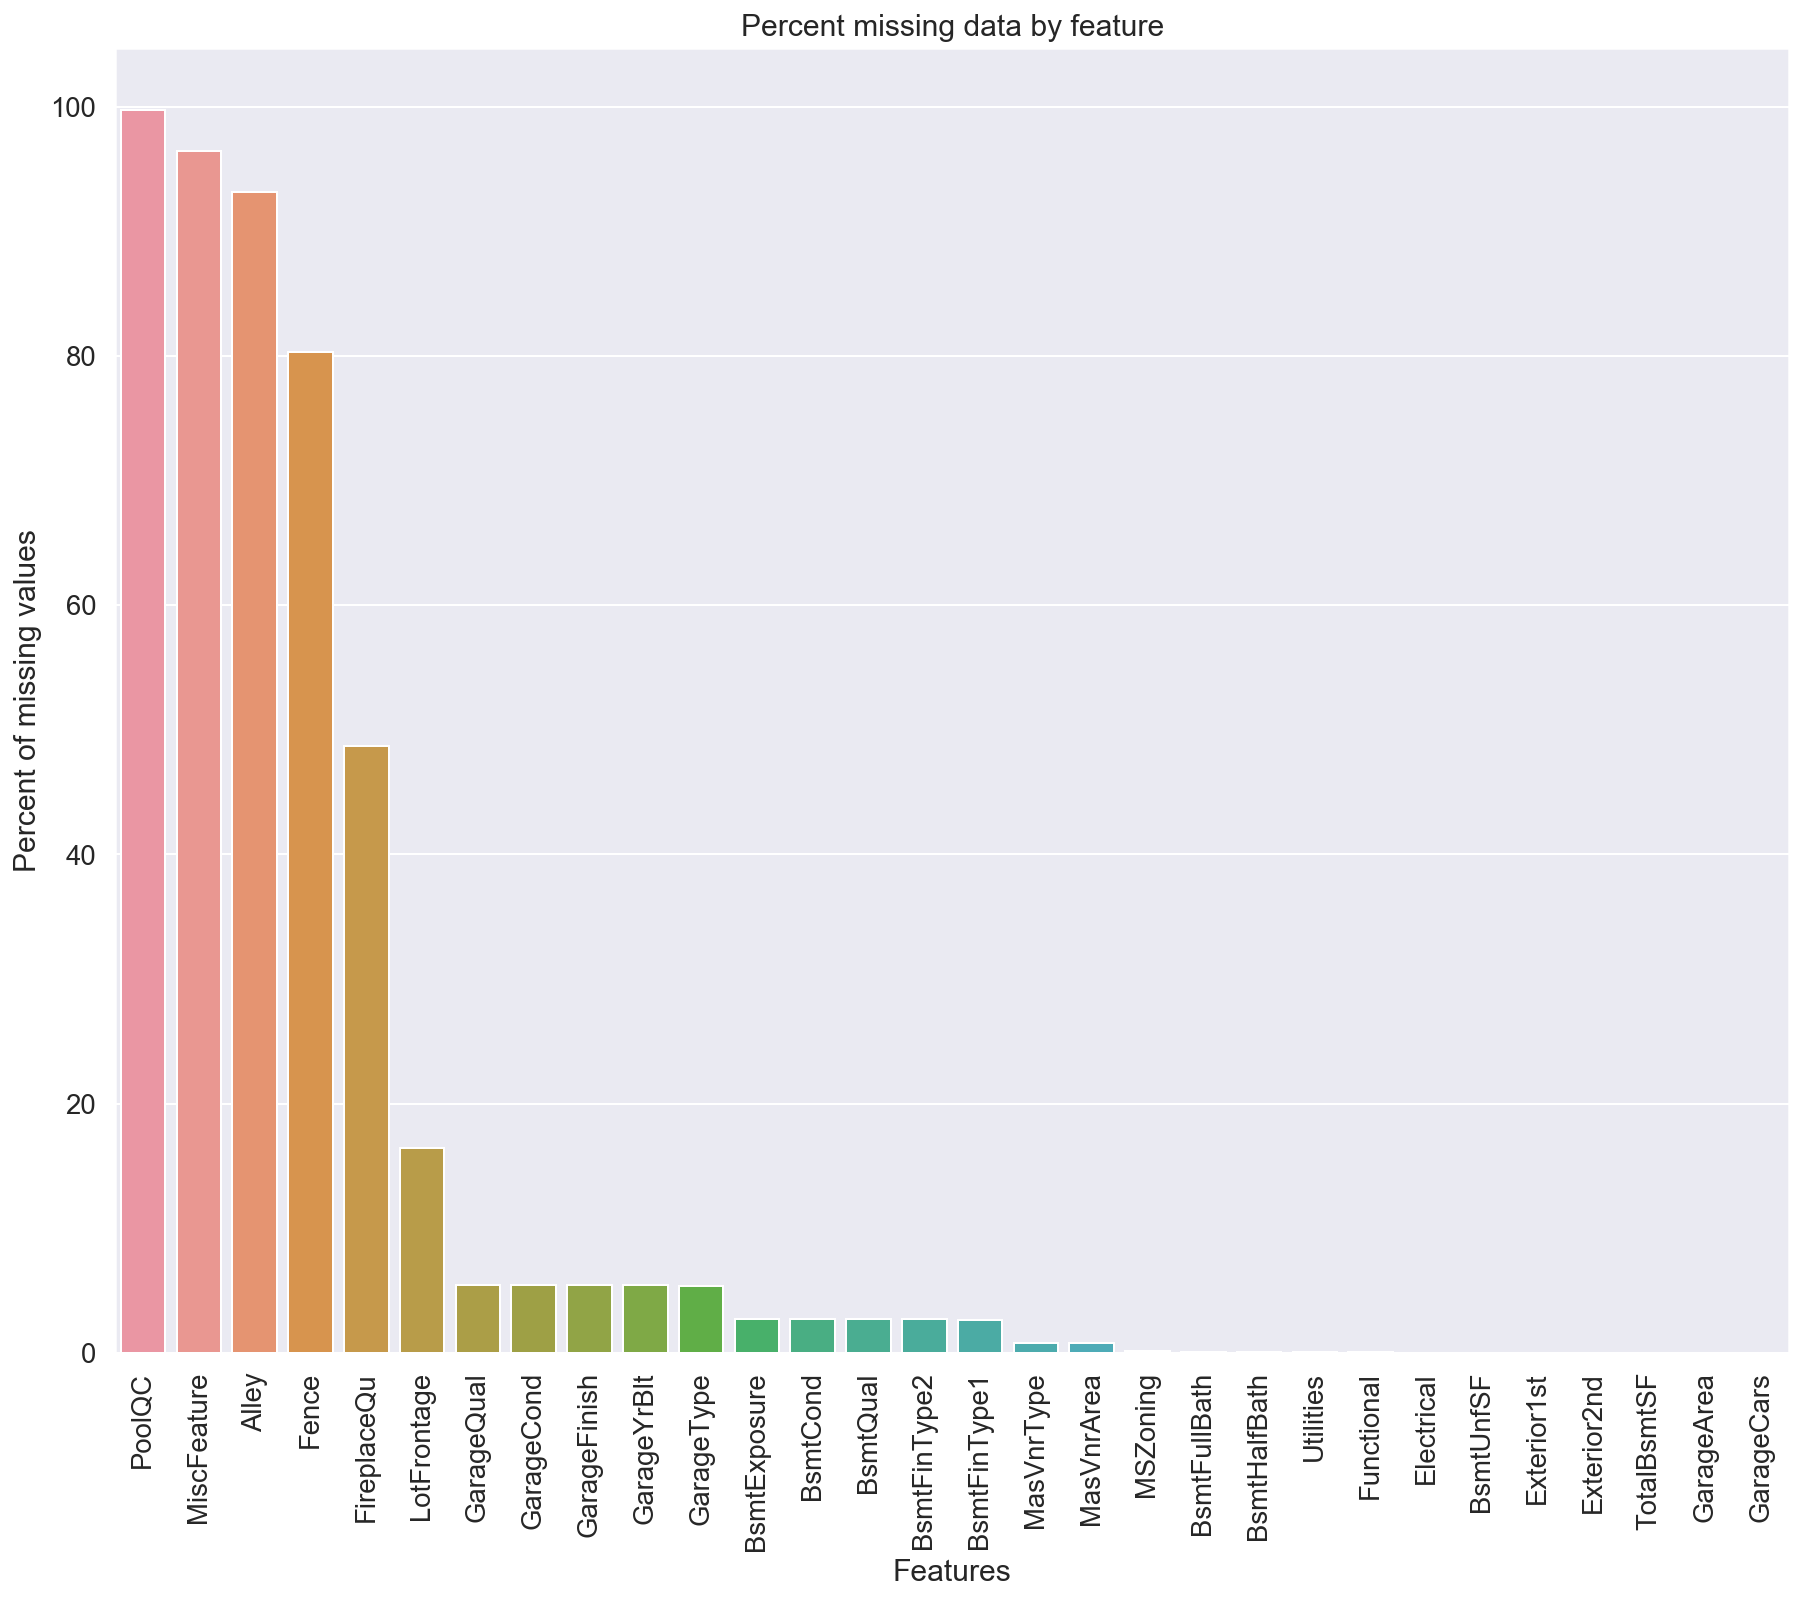

In [30]:
# Percent missing data by feature
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Imputing Missing Values

In [31]:
#Inputting missing values
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [32]:
# Check if there are any missing values left
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [33]:
#Check all data
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,None,3,1Fam,TA,No,706.0,0.0,...,Normal,WD,0,Pave,8,856.0,0,2003,2003,2008
1,1262,0,0,None,3,1Fam,TA,Gd,978.0,0.0,...,Normal,WD,0,Pave,6,1262.0,298,1976,1976,2007
2,920,866,0,None,3,1Fam,TA,Mn,486.0,0.0,...,Normal,WD,0,Pave,6,920.0,0,2001,2002,2008
3,961,756,0,None,3,1Fam,Gd,No,216.0,0.0,...,Abnorml,WD,0,Pave,7,756.0,0,1915,1970,2006
4,1145,1053,0,None,4,1Fam,TA,Av,655.0,0.0,...,Normal,WD,0,Pave,9,1145.0,192,2000,2000,2008


5. Feature Transformation/Engineering

In [34]:
#MSSubClass =The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [35]:
# Adding Total Square Feet feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [36]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [37]:
train['SalePrice'] = SalePrice

Building tree

In [38]:
from __future__ import print_function

In [39]:
header = list(train.columns.values)


In [40]:
train = train.values
test = test.values


In [41]:
def unique_vals(rows, col):
    return set([row[col] for row in rows])

In [42]:
def class_counts(rows):
    counts = {}  
    for row in rows:
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [43]:
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

In [44]:
class Question:

    def __init__(self, column, value):
        self.column = column  
        self.value = value    

    def match(self, example):
        val = example[self.column]  
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value 

    def __repr__(self):
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (header[self.column], condition, str(self.value))

In [45]:
def partition(rows, question):   # partition to two halfs one that matches the question and another that doesnt
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [46]:
def gini(rows):
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows)) #probabilty of a label
        impurity -= prob_of_lbl**2
    return impurity

In [47]:
def info_gain(left, right, current_uncertainty):  #the bigger infogain the better
    p = float(len(left)) / (len(left) + len(right))
    infogain =  current_uncertainty - p * gini(left) - (1 - p) * gini(right)
    return infogain

In [48]:
def find_best_split(rows):
    best_gain = 0  
    best_question = None 
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1  

    for col in range(n_features): 
        values = set([row[col] for row in rows])  
        for val in values:  
            question = Question(col, val)  
            true_rows, false_rows = partition(rows, question)
            
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            gain = info_gain(true_rows, false_rows, current_uncertainty)

            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

Generating tree

In [49]:
class Leaf:

    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [50]:
class Decision_Node:

    def __init__(self, question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [51]:
def build_tree(rows):

    gain, question = find_best_split(rows)
    print("gain, question:", gain, question )

    if gain == 0:
        print("added to leaf :", rows)
        return Leaf(rows)

    true_rows, false_rows = partition(rows, question)

    true_branch = build_tree(true_rows)
    
    false_branch = build_tree(false_rows)

    print("came to last return: ", question, true_branch, false_branch)
    return Decision_Node(question, true_branch, false_branch)

In [ ]:
my_tree = build_tree(train)

gain, question: 0.001379884262183051 Is BsmtCond == Po?
gain, question: 0.0 Is TotalSF >= 2038.0?
added to leaf : [array([904, 0, 0, 'None', 1, '1Fam', 'Po', 'Gd', 350.0, 0.0, 'BLQ', 'Unf',
       1.0, 0.0, 'Fa', 333.0, 'N', 'Norm', 'Norm', 'FuseA', 0, 'Fa', 'Fa',
       'Wd Sdng', 'Wd Sdng', 'None', 'None', 0, 'BrkTil', 0, 'Maj1', 0.0,
       0.0, 'None', 'None', 'None', 'None', 0.0, 904, 1, 'GasA', 'Gd',
       '1Story', 1, 'Fa', 'Low', 'Sev', 10020, 'Inside', 64.5, 'IR1', 0,
       '30', 'RL', 0.0, 'None', 'None', 0, '3', 'Edwards', 0, '1', 1, 'Y',
       0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0, 'Pave', 4, 683.0,
       0, 1922, 1950, '2009', 1587.0, 123000], dtype=object), array([1077, 0, 0, 'None', 2, '1Fam', 'Po', 'No', 0.0, 0.0, 'Unf', 'Unf',
       0.0, 0.0, 'Fa', 961.0, 'Y', 'Norm', 'Norm', 'Mix', 0, 'Fa', 'TA',
       'MetalSd', 'MetalSd', 'None', 'None', 0, 'BrkTil', 1, 'Maj2',
       338.0, 1.0, 'Po', 'Unf', 'Po', 'Detchd', 1920.0, 1077, 0, 'GasA',
       'Gd', '1S

gain, question: 0.0013000506508610288 Is PavedDrive == N?
gain, question: 0.0886426592797791 Is YearRemodAdd >= 1952?
gain, question: 0.07692307692307693 Is TotalSF >= 1728.0?
gain, question: 0.11111111111111077 Is TotalSF >= 2232.0?
gain, question: 0.2500000000000001 Is TotalSF >= 2920.0?
gain, question: 0.3333333333333332 Is TotalSF >= 3368.0?
gain, question: 0.5 Is TotalSF >= 3444.0?
gain, question: 0 None
added to leaf : [array([1362, 720, 0, 'None', 3, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf',
       'Unf', 0.0, 0.0, 'Gd', 1362.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'VinylSd', 'VinylSd', 'None', 'None', 0, 'PConc', 2,
       'Mod', 484.0, 2.0, 'TA', 'Unf', 'TA', 'Detchd', 2003.0, 2082, 1,
       'GasA', 'Ex', '1.5Fin', 1, 'Gd', 'Lvl', 'Gtl', 11426, 'Inside',
       63.0, 'Reg', 0, '50', 'RM', 0.0, 'None', 'None', 0, '6', 'OldTown',
       238, '5', 7, 'N', 0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0,
       'Pave', 6, 1362.0, 280, 2003, 2003, '2008', 3444.0, 200000

gain, question: 0.001345945308008245 Is LotShape == IR3?
gain, question: 0.24489795918367352 Is TotRmsAbvGrd >= 9?
gain, question: 0.0 Is TotalSF >= 3480.0?
added to leaf : [array([1210, 1242, 0, 'None', 4, '1Fam', 'TA', 'No', 281.0, 0.0, 'GLQ',
       'Unf', 0.0, 0.0, 'Gd', 747.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'VinylSd', 'VinylSd', 'None', 'TA', 1, 'PConc', 2,
       'Typ', 683.0, 2.0, 'TA', 'Fin', 'TA', 'BuiltIn', 1998.0, 2452, 1,
       'GasA', 'Ex', '2Story', 1, 'Gd', 'Lvl', 'Gtl', 16226, 'Inside',
       66.0, 'IR3', 0, '60', 'RL', 0.0, 'None', 'None', 0, '5', 'CollgCr',
       50, '5', 8, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0,
       'Pave', 9, 1028.0, 208, 1998, 1999, '2007', 3480.0, 157000],
      dtype=object), array([887, 1134, 0, 'None', 3, '1Fam', 'Gd', 'No', 0.0, 0.0, 'Unf',
       'Unf', 0.0, 0.0, 'Ex', 868.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'VinylSd', 'VinylSd', 'None', 'Gd', 1, 'PConc', 2,
       'Typ', 422.0, 2.

gain, question: 0.0013601167759876853 Is OverallQual >= 10?
gain, question: 0.1044444444444439 Is LotFrontage >= 114.0?
gain, question: 0.4444444444444445 Is TotalSF >= 6872.0?
gain, question: 0 None
added to leaf : [array([2411, 2065, 0, 'None', 4, '1Fam', 'TA', 'Av', 2096.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Ex', 300.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'Wd Sdng', 'ImStucc', 'MnPrv', 'TA', 2, 'PConc', 3,
       'Typ', 813.0, 3.0, 'TA', 'Fin', 'TA', 'Attchd', 1996.0, 4476, 1,
       'GasA', 'Ex', '2Story', 1, 'Ex', 'Lvl', 'Gtl', 15623, 'Corner',
       160.0, 'IR1', 0, '60', 'RL', 0.0, 'None', 'None', 0, '7',
       'NoRidge', 78, '5', 10, 'Y', 555, 'Ex', 'CompShg', 'Hip',
       'Abnorml', 'WD', 0, 'Pave', 10, 2396.0, 171, 1996, 1996, '2007',
       6872.0, 239000], dtype=object)]
gain, question: 0.0 Is TotalSF >= 5557.0?
added to leaf : [array([2084, 0, 0, 'None', 2, '1Fam', 'TA', 'Av', 1636.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Ex', 442.0, 'Y', 'PosN', 'PosN'

gain, question: 0.0014066764607489901 Is TotalSF >= 4860.0?
gain, question: 0.24489795918367352 Is LotShape == IR1?
gain, question: 0.0 Is TotalSF >= 5271.0?
added to leaf : [array([1992, 876, 0, 'None', 4, '1Fam', 'TA', 'Av', 240.0, 0.0, 'GLQ',
       'Unf', 0.0, 0.0, 'Ex', 1752.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'CemntBd', 'CmentBd', 'None', 'Gd', 1, 'PConc', 3,
       'Typ', 716.0, 3.0, 'TA', 'Fin', 'TA', 'BuiltIn', 2005.0, 2868, 1,
       'GasA', 'Ex', '2Story', 1, 'Ex', 'Lvl', 'Gtl', 16056, 'Inside',
       85.0, 'IR1', 0, '60', 'RL', 208.0, 'Stone', 'None', 0, '7',
       'StoneBr', 108, '5', 9, 'Y', 0, 'None', 'CompShg', 'Hip',
       'Partial', 'New', 0, 'Pave', 11, 1992.0, 214, 2005, 2006, '2006',
       4860.0, 155000], dtype=object), array([2053, 1185, 0, 'None', 4, '1Fam', 'TA', 'Av', 816.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Gd', 1217.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'VinylSd', 'VinylSd', 'None', 'Ex', 1, 'PConc', 2,
       'Typ'

gain, question: 0.0013947797249906912 Is LotArea >= 35133?
gain, question: 0.21875 Is YearRemodAdd >= 1987?
gain, question: 0.16666666666666674 Is TotalSF >= 3027.0?
gain, question: 0.19999999999999996 Is TotalSF >= 3684.0?
gain, question: 0.5 Is TotalSF >= 4077.0?
gain, question: 0 None
added to leaf : [array([1686, 762, 0, 'None', 4, '1Fam', 'Gd', 'No', 1361.0, 180.0, 'GLQ',
       'Rec', 1.0, 0.0, 'Gd', 88.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0, 'TA',
       'Gd', 'VinylSd', 'VinylSd', 'None', 'TA', 1, 'PConc', 2, 'Typ',
       711.0, 3.0, 'TA', 'RFn', 'TA', 'Attchd', 1994.0, 2448, 1, 'GasA',
       'Ex', '2Story', 1, 'Gd', 'Lvl', 'Gtl', 46589, 'CulDSac', 52.0,
       'IR2', 0, '60', 'RL', 528.0, 'BrkFace', 'None', 0, '7', 'NoRidge',
       76, '7', 8, 'Y', 0, 'None', 'CompShg', 'Hip', 'Normal', 'WD', 0,
       'Pave', 8, 1629.0, 517, 1994, 2005, '2009', 4077.0, 145500],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([1842, 0, 0, 'None', 0, '1Fam', 'TA', 'Gd', 1810.0

gain, question: 0.0013503436419254333 Is Neighborhood == Gilbert?
gain, question: 0.02447853777493747 Is LotConfig == CulDSac?
gain, question: 0.31999999999999995 Is TotalSF >= 2961.0?
gain, question: 0.3333333333333332 Is TotalSF >= 3340.0?
gain, question: 0.5 Is TotalSF >= 3492.0?
gain, question: 0 None
added to leaf : [array([1746, 0, 0, 'None', 3, '1Fam', 'TA', 'Gd', 1320.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Ex', 426.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Ex', 'VinylSd', 'VinylSd', 'None', 'Gd', 2, 'PConc', 2,
       'Typ', 758.0, 3.0, 'TA', 'Fin', 'TA', 'Attchd', 2006.0, 1746, 0,
       'GasA', 'Ex', '1Story', 1, 'Ex', 'HLS', 'Gtl', 14892, 'CulDSac',
       42.0, 'IR1', 0, '20', 'RL', 160.0, 'Stone', 'None', 0, '10',
       'Gilbert', 39, '5', 9, 'Y', 0, 'None', 'CompShg', 'Gable',
       'Normal', 'WD', 0, 'Pave', 7, 1746.0, 201, 2006, 2007, '2009',
       3492.0, 91000], dtype=object)]
gain, question: 0 None
added to leaf : [array([1670, 0, 0, 'None', 3, '1Fam', 'T

gain, question: 0.058823529411764164 Is TotalSF >= 2614.0?
gain, question: 0.2500000000000001 Is TotalSF >= 2617.0?
gain, question: 0.3333333333333332 Is TotalSF >= 2630.0?
gain, question: 0.5 Is TotalSF >= 2632.0?
gain, question: 0 None
added to leaf : [array([1316, 0, 23, 'None', 3, '1Fam', 'TA', 'No', 28.0, 0.0, 'GLQ',
       'Unf', 0.0, 0.0, 'Gd', 1288.0, 'Y', 'RRAn', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'VinylSd', 'VinylSd', 'None', 'Gd', 1, 'PConc', 2,
       'Typ', 397.0, 2.0, 'TA', 'Fin', 'TA', 'Attchd', 2005.0, 1316, 0,
       'GasA', 'Ex', '1Story', 1, 'Gd', 'Lvl', 'Gtl', 10237, 'Inside',
       65.0, 'Reg', 0, '20', 'RL', 0.0, 'None', 'None', 0, '10',
       'Gilbert', 0, '5', 6, 'Y', 0, 'None', 'CompShg', 'Gable',
       'Partial', 'New', 0, 'Pave', 6, 1316.0, 100, 2005, 2006, '2006',
       2632.0, 35311], dtype=object)]
gain, question: 0 None
added to leaf : [array([959, 712, 0, 'None', 3, '1Fam', 'TA', 'No', 786.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Gd', 173.0, 'Y', 

gain, question: 0.00146731056045446 Is LandContour == HLS?
gain, question: 0.044814814814816084 Is BsmtUnfSF >= 604.0?
gain, question: 0.12500000000000022 Is KitchenQual == Ex?
gain, question: 0.0 Is TotalSF >= 4020.0?
added to leaf : [array([1484, 0, 0, 'None', 2, '1Fam', 'TA', 'Av', 428.0, 0.0, 'GLQ',
       'Unf', 0.0, 0.0, 'Gd', 1048.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'VinylSd', 'VinylSd', 'None', 'Gd', 1, 'PConc', 2,
       'Typ', 472.0, 2.0, 'TA', 'RFn', 'TA', 'Attchd', 2006.0, 1484, 0,
       'GasA', 'Ex', '1Story', 1, 'Ex', 'HLS', 'Gtl', 9037, 'Inside',
       64.0, 'IR1', 0, '20', 'RL', 32.0, 'BrkFace', 'None', 0, '12',
       'Timber', 33, '5', 8, 'Y', 0, 'None', 'CompShg', 'Hip', 'Normal',
       'WD', 0, 'Pave', 6, 1476.0, 120, 2006, 2006, '2007', 2960.0,
       190000], dtype=object), array([2018, 0, 0, 'None', 3, '1Fam', 'TA', 'Gd', 0.0, 0.0, 'Unf', 'Unf',
       0.0, 0.0, 'Ex', 2002.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0, 'TA',
       'Ex', 'Stucco', 'Cme

gain, question: 0.0014905476998977596 Is Neighborhood == Edwards?
gain, question: 0.06693971022151568 Is MSSubClass == 60?
gain, question: 0.0 Is TotalSF >= 2402.0?
added to leaf : [array([698, 728, 0, 'None', 3, '1Fam', 'TA', 'No', 535.0, 0.0, 'BLQ',
       'Unf', 0.0, 0.0, 'TA', 155.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'HdBoard', 'Plywood', 'MnPrv', 'None', 0, 'CBlock', 1,
       'Typ', 440.0, 2.0, 'TA', 'Fin', 'TA', 'Attchd', 1977.0, 1426, 1,
       'GasA', 'TA', '2Story', 1, 'TA', 'Bnk', 'Gtl', 7950, 'Corner',
       75.0, 'IR1', 0, '60', 'RL', 140.0, 'BrkFace', 'None', 0, '7',
       'Edwards', 0, '6', 6, 'Y', 0, 'None', 'CompShg', 'Hip', 'Normal',
       'WD', 0, 'Pave', 6, 690.0, 252, 1977, 1977, '2009', 2116.0, 178000],
      dtype=object), array([760, 896, 0, 'None', 3, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf', 'Unf',
       0.0, 0.0, 'Gd', 746.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0, 'TA', 'Gd',
       'VinylSd', 'VinylSd', 'None', 'Gd', 1, 'PConc', 2, 'Typ', 397.0,
 

gain, question: 0.0015477967084492894 Is WoodDeckSF >= 216?
gain, question: 0.01156517767137466 Is Fence == GdWo?
gain, question: 0.375 Is YearRemodAdd >= 1995?
gain, question: 0.0 Is TotalSF >= 4175.0?
added to leaf : [array([1212, 0, 0, 'None', 3, '1Fam', 'Gd', 'Av', 506.0, 0.0, 'ALQ',
       'Unf', 1.0, 0.0, 'Gd', 0.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0, 'TA',
       'TA', 'HdBoard', 'Plywood', 'GdWo', 'TA', 1, 'CBlock', 1, 'Typ',
       492.0, 2.0, 'TA', 'Unf', 'TA', 'Attchd', 1978.0, 1212, 0, 'GasA',
       'TA', 'SLvl', 1, 'TA', 'Lvl', 'Gtl', 8471, 'Corner', 88.0, 'IR1',
       0, '80', 'RL', 46.0, 'BrkFace', 'None', 0, '7', 'Sawyer', 12, '7',
       6, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0, 'Pave',
       6, 506.0, 292, 1977, 1995, '2006', 1718.0, 151000], dtype=object), array([1968, 1479, 0, 'None', 4, '1Fam', 'TA', 'Mn', 192.0, 0.0, 'Rec',
       'Unf', 0.0, 0.0, 'TA', 536.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'Gd', 'TA', 'Stucco', 'Stucco', 'GdWo', 'Gd', 2, 

gain, question: 0.010873465958532447 Is MoSold == 11?
gain, question: 0.24489795918367352 Is YearRemodAdd >= 1995?
gain, question: 0.19999999999999996 Is TotalSF >= 3534.0?
gain, question: 0.5 Is TotalSF >= 3849.0?
gain, question: 0 None
added to leaf : [array([1328, 1203, 0, 'None', 4, '1Fam', 'TA', 'Av', 56.0, 64.0, 'LwQ',
       'ALQ', 0.0, 0.0, 'Gd', 1198.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'VinylSd', 'VinylSd', 'None', 'TA', 1, 'PConc', 2,
       'Typ', 752.0, 3.0, 'TA', 'RFn', 'TA', 'Attchd', 1995.0, 2531, 1,
       'GasA', 'Ex', '2Story', 1, 'Gd', 'Lvl', 'Gtl', 12257, 'Inside',
       65.0, 'IR1', 0, '60', 'RL', 513.0, 'BrkFace', 'None', 0, '11',
       'NoRidge', 98, '5', 8, 'Y', 0, 'None', 'CompShg', 'Gable',
       'Normal', 'WD', 0, 'Pave', 9, 1318.0, 222, 1995, 1995, '2007',
       3849.0, 275500], dtype=object)]
gain, question: 0 None
added to leaf : [array([1158, 1218, 0, 'None', 4, '1Fam', 'TA', 'Av', 0.0, 0.0, 'Unf',
       'Unf', 0.0, 0.0, 'Ex', 1158

gain, question: 0.015063327286162921 Is GarageYrBlt >= 1971.0?
gain, question: 0.014948253921655774 Is LotFrontage >= 71.5?
gain, question: 0.026905456059973853 Is WoodDeckSF >= 236?
gain, question: 0.022727272727275066 Is TotalSF >= 2370.0?
gain, question: 0.026315789473683668 Is TotalSF >= 2759.0?
gain, question: 0.030303030303030054 Is TotalSF >= 4656.0?
gain, question: 0.5 Is TotalSF >= 4796.0?
gain, question: 0 None
added to leaf : [array([2069, 574, 0, 'None', 3, '1Fam', 'TA', 'Av', 0.0, 0.0, 'Unf',
       'Unf', 0.0, 0.0, 'Gd', 2153.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Ex', 'VinylSd', 'VinylSd', 'None', 'Gd', 1, 'PConc', 2,
       'Typ', 694.0, 3.0, 'TA', 'Fin', 'TA', 'BuiltIn', 2006.0, 2643, 1,
       'GasA', 'Ex', '2Story', 1, 'Ex', 'Lvl', 'Gtl', 13693, 'Inside',
       105.0, 'Reg', 0, '60', 'RL', 772.0, 'BrkFace', 'None', 0, '3',
       'NridgHt', 84, '5', 9, 'Y', 0, 'None', 'CompShg', 'Hip', 'Normal',
       'WD', 0, 'Pave', 9, 2153.0, 414, 2006, 2006, '2007', 

gain, question: 0.3333333333333332 Is TotalSF >= 2970.0?
gain, question: 0.5 Is TotalSF >= 3608.0?
gain, question: 0 None
added to leaf : [array([1277, 1067, 0, 'None', 3, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf',
       'Unf', 0.0, 0.0, 'Gd', 1264.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'VinylSd', 'VinylSd', 'None', 'TA', 1, 'PConc', 2,
       'Typ', 889.0, 3.0, 'TA', 'RFn', 'TA', 'Attchd', 1996.0, 2344, 1,
       'GasA', 'Ex', '2Story', 1, 'Gd', 'Lvl', 'Gtl', 10208, 'Inside',
       79.0, 'IR1', 0, '60', 'RL', 921.0, 'BrkFace', 'None', 0, '7',
       'NoRidge', 0, '5', 7, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal',
       'WD', 0, 'Pave', 7, 1264.0, 220, 1996, 1997, '2009', 3608.0, 96500],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([1509, 0, 0, 'None', 3, '1Fam', 'TA', 'Av', 783.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Gd', 678.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'HdBoard', 'HdBoard', 'None', 'Fa', 1, 'CBlock', 2,
       'Typ', 60

gain, question: 0.06666666666666665 Is TotalSF >= 2649.0?
gain, question: 0.16666666666666674 Is TotalSF >= 2747.0?
gain, question: 0.3333333333333332 Is TotalSF >= 2900.0?
gain, question: 0.5 Is TotalSF >= 3091.0?
gain, question: 0 None
added to leaf : [array([1057, 977, 0, 'None', 3, '1Fam', 'TA', 'No', 739.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Gd', 318.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'VinylSd', 'VinylSd', 'GdPrv', 'None', 0, 'PConc', 2,
       'Typ', 645.0, 2.0, 'TA', 'RFn', 'TA', 'Attchd', 1998.0, 2034, 1,
       'GasA', 'Ex', '2Story', 1, 'Gd', 'Lvl', 'Gtl', 9375, 'Inside',
       70.0, 'Reg', 0, '60', 'RL', 573.0, 'BrkFace', 'None', 0, '2',
       'CollgCr', 36, '5', 7, 'Y', 0, 'None', 'CompShg', 'Gable',
       'Normal', 'WD', 0, 'Pave', 8, 1057.0, 576, 1997, 1998, '2009',
       3091.0, 219500], dtype=object)]
gain, question: 0 None
added to leaf : [array([1055, 790, 0, 'None', 3, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf',
       'Unf', 0.0, 0.0, 'Gd', 1055.0

gain, question: 0.0019480802670523156 Is LandSlope == Gtl?
gain, question: 0.0019684527634433527 Is GarageCond == TA?
gain, question: 0.002008076573753792 Is OpenPorchSF >= 25?
gain, question: 0.0033294607225371475 Is GarageYrBlt >= 1979.0?
gain, question: 0.004138042612495618 Is BsmtUnfSF >= 1753.0?
gain, question: 0.1604938271604935 Is BsmtUnfSF >= 1777.0?
gain, question: 0.16666666666666674 Is TotalSF >= 3738.0?
gain, question: 0.3333333333333332 Is TotalSF >= 3810.0?
gain, question: 0.5 Is TotalSF >= 4242.0?
gain, question: 0 None
added to leaf : [array([2121, 0, 0, 'None', 3, '1Fam', 'TA', 'Gd', 0.0, 0.0, 'Unf', 'Unf',
       0.0, 0.0, 'Ex', 2121.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0, 'TA',
       'Ex', 'CemntBd', 'CmentBd', 'None', 'Ex', 1, 'PConc', 2, 'Typ',
       732.0, 3.0, 'TA', 'Fin', 'TA', 'Attchd', 2007.0, 2121, 1, 'GasA',
       'Ex', '1Story', 1, 'Ex', 'Lvl', 'Gtl', 14450, 'Inside', 107.0,
       'Reg', 0, '20', 'RL', 315.0, 'BrkFace', 'None', 0, '5', 'NridgHt',
       98,

gain, question: 0.005990451299527012 Is Condition1 == Norm?
gain, question: 0.005669049361984313 Is LotFrontage >= 107.0?
gain, question: 0.11983471074380203 Is BsmtUnfSF >= 1560.0?
gain, question: 0.375 Is TotalSF >= 3259.0?
gain, question: 0.0 Is TotalSF >= 4556.0?
added to leaf : [array([1734, 1088, 0, 'None', 4, '1Fam', 'TA', 'Gd', 0.0, 0.0, 'Unf',
       'Unf', 0.0, 0.0, 'Ex', 1734.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Ex', 'VinylSd', 'VinylSd', 'None', 'Gd', 1, 'PConc', 3,
       'Typ', 1020.0, 3.0, 'TA', 'RFn', 'TA', 'BuiltIn', 2009.0, 2822, 1,
       'GasA', 'Ex', '2Story', 1, 'Ex', 'Lvl', 'Gtl', 13891, 'Inside',
       107.0, 'Reg', 0, '60', 'RL', 424.0, 'Stone', 'None', 0, '1',
       'NridgHt', 170, '5', 9, 'Y', 0, 'None', 'CompShg', 'Hip',
       'Partial', 'New', 192, 'Pave', 12, 1734.0, 52, 2008, 2009, '2009',
       4556.0, 110000], dtype=object), array([1636, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 63.0, 0.0, 'GLQ', 'Unf',
       1.0, 0.0, 'Gd', 1560.0, 'Y', 'N

gain, question: 0.006175339368260979 Is BsmtFinSF1 >= 28.0?
gain, question: 0.009061514609426724 Is GrLivArea >= 1652?
gain, question: 0.013339024711333525 Is BsmtUnfSF >= 628.0?
gain, question: 0.09585798816568014 Is YearBuilt >= 2002?
gain, question: 0.12500000000000017 Is TotalSF >= 3353.0?
gain, question: 0.19999999999999996 Is TotalSF >= 3688.0?
gain, question: 0.5 Is TotalSF >= 3794.0?
gain, question: 0 None
added to leaf : [array([1184, 1426, 0, 'None', 4, '1Fam', 'TA', 'Av', 64.0, 0.0, 'GLQ',
       'Unf', 0.0, 0.0, 'Gd', 1120.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'CemntBd', 'CmentBd', 'None', 'Gd', 1, 'PConc', 2,
       'Typ', 550.0, 2.0, 'TA', 'Fin', 'TA', 'BuiltIn', 2007.0, 2610, 1,
       'GasA', 'Ex', '2Story', 1, 'Ex', 'Lvl', 'Gtl', 9000, 'Inside',
       75.0, 'Reg', 0, '60', 'FV', 0.0, 'None', 'None', 0, '8', 'Somerst',
       364, '5', 8, 'Y', 0, 'None', 'CompShg', 'Gable', 'Partial', 'New',
       0, 'Pave', 11, 1184.0, 208, 2007, 2007, '2007', 3794.0

gain, question: 0.015941553166610833 Is MasVnrArea >= 246.0?
gain, question: 0.06804733727810863 Is MasVnrArea >= 262.0?
gain, question: 0.04166666666666652 Is TotalSF >= 4450.0?
gain, question: 0.5 Is TotalSF >= 4694.0?
gain, question: 0 None
added to leaf : [array([2364, 0, 0, 'None', 2, '1Fam', 'TA', 'Gd', 2188.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Ex', 142.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Ex', 'VinylSd', 'VinylSd', 'None', 'Gd', 2, 'PConc', 2,
       'Typ', 820.0, 3.0, 'TA', 'Fin', 'TA', 'Attchd', 2009.0, 2364, 1,
       'GasA', 'Ex', '1Story', 1, 'Ex', 'Lvl', 'Gtl', 12919, 'Inside',
       100.0, 'IR1', 0, '20', 'RL', 760.0, 'Stone', 'None', 0, '3',
       'NridgHt', 67, '5', 9, 'Y', 0, 'None', 'CompShg', 'Hip', 'Partial',
       'New', 0, 'Pave', 11, 2330.0, 0, 2009, 2010, '2010', 4694.0,
       154500], dtype=object)]
gain, question: 0 None
added to leaf : [array([2234, 0, 0, 'None', 1, '1Fam', 'TA', 'No', 1904.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Ex', 312.

gain, question: 0.3333333333333332 Is TotalSF >= 3010.0?
gain, question: 0.5 Is TotalSF >= 3211.0?
gain, question: 0 None
added to leaf : [array([1164, 896, 0, 'None', 4, '1Fam', 'TA', 'No', 831.0, 0.0, 'GLQ',
       'Unf', 0.0, 1.0, 'Gd', 320.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'Plywood', 'Plywood', 'None', 'TA', 1, 'PConc', 2,
       'Typ', 521.0, 2.0, 'TA', 'Unf', 'TA', 'Attchd', 1988.0, 2060, 1,
       'GasA', 'TA', '2Story', 1, 'TA', 'Lvl', 'Gtl', 10029, 'Corner',
       97.0, 'IR1', 0, '60', 'RL', 268.0, 'BrkFace', 'None', 0, '9',
       'ClearCr', 228, '5', 6, 'Y', 0, 'None', 'CompShg', 'Gable',
       'Normal', 'WD', 192, 'Pave', 8, 1151.0, 0, 1988, 1989, '2007',
       3211.0, 211000], dtype=object)]
gain, question: 0 None
added to leaf : [array([1086, 838, 0, 'None', 3, '1Fam', 'TA', 'Av', 956.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Gd', 130.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'VinylSd', 'VinylSd', 'None', 'TA', 1, 'PConc', 2,
       'Typ

gain, question: 0.03225806451612878 Is TotalSF >= 3408.0?
gain, question: 0.3333333333333332 Is TotalSF >= 3438.0?
gain, question: 0.5 Is TotalSF >= 3452.0?
gain, question: 0 None
added to leaf : [array([1726, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 1126.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Ex', 600.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Ex', 'CemntBd', 'CmentBd', 'None', 'Gd', 1, 'PConc', 2,
       'Typ', 786.0, 3.0, 'TA', 'Fin', 'TA', 'Attchd', 2007.0, 1726, 0,
       'GasA', 'Ex', '1Story', 1, 'Ex', 'Lvl', 'Gtl', 9416, 'Inside',
       79.0, 'Reg', 0, '20', 'RL', 205.0, 'Stone', 'None', 0, '9',
       'Somerst', 138, '5', 7, 'Y', 0, 'None', 'CompShg', 'Hip',
       'Partial', 'New', 266, 'Pave', 8, 1726.0, 171, 2007, 2007, '2007',
       3452.0, 311872], dtype=object)]
gain, question: 0 None
added to leaf : [array([1719, 0, 0, 'None', 1, 'TwnhsE', 'TA', 'Gd', 1619.0, 0.0, 'GLQ',
       'Unf', 2.0, 0.0, 'Gd', 100.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'BrkF

added to leaf : [array([804, 878, 0, 'None', 3, '1Fam', 'TA', 'No', 505.0, 0.0, 'GLQ',
       'Unf', 0.0, 0.0, 'Gd', 299.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'VinylSd', 'VinylSd', 'None', 'None', 0, 'PConc', 2,
       'Typ', 523.0, 2.0, 'TA', 'RFn', 'TA', 'Attchd', 1998.0, 1682, 1,
       'GasA', 'Ex', '2Story', 1, 'Gd', 'Lvl', 'Gtl', 8750, 'Inside',
       70.0, 'Reg', 0, '60', 'RL', 116.0, 'BrkFace', 'None', 0, '6',
       'CollgCr', 77, '5', 6, 'Y', 0, 'None', 'CompShg', 'Gable',
       'Normal', 'WD', 0, 'Pave', 7, 804.0, 0, 1998, 1998, '2010', 2486.0,
       148500], dtype=object)]
came to last return:  Is TotalSF >= 2488.0? <__main__.Decision_Node object at 0x000001DA0042F128> <__main__.Leaf object at 0x000001DA00434860>
came to last return:  Is TotalSF >= 2590.0? <__main__.Leaf object at 0x000001DA0043CE48> <__main__.Decision_Node object at 0x000001DA00434438>
came to last return:  Is TotalSF >= 2610.0? <__main__.Decision_Node object at 0x000001DA0043CD68> <__m

gain, question: 0.04166666666666652 Is TotalSF >= 3122.0?
gain, question: 0.5 Is TotalSF >= 3126.0?
gain, question: 0 None
added to leaf : [array([1563, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 33.0, 0.0, 'GLQ', 'Unf',
       0.0, 0.0, 'Gd', 1530.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0, 'TA',
       'TA', 'VinylSd', 'VinylSd', 'None', 'Gd', 1, 'PConc', 2, 'Typ',
       758.0, 3.0, 'TA', 'RFn', 'TA', 'Attchd', 2007.0, 1563, 0, 'GasA',
       'Ex', '1Story', 1, 'Gd', 'Lvl', 'Gtl', 10206, 'Inside', 78.0,
       'Reg', 0, '20', 'RL', 468.0, 'Stone', 'None', 0, '10', 'Somerst',
       99, '5', 8, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0,
       'Pave', 6, 1563.0, 144, 2007, 2007, '2008', 3126.0, 245000],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([1561, 0, 0, 'None', 2, 'TwnhsE', 'TA', 'No', 1153.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Ex', 408.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Ex', 'MetalSd', 'MetalSd', 'None', 'Gd', 1, 'PConc', 2,
       'Typ', 

gain, question: 0.017701726964489684 Is YrSold == 2006?
gain, question: 0.11162646876932614 Is FireplaceQu == TA?
gain, question: 0.4444444444444444 Is TotalSF >= 3404.0?
gain, question: 0 None
added to leaf : [array([1165, 1098, 0, 'None', 4, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf',
       'Unf', 0.0, 0.0, 'Gd', 1141.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'VinylSd', 'VinylSd', 'None', 'TA', 1, 'PConc', 2,
       'Typ', 420.0, 2.0, 'TA', 'Fin', 'TA', 'BuiltIn', 1998.0, 2263, 1,
       'GasA', 'Gd', '2Story', 1, 'Gd', 'Lvl', 'Gtl', 12090, 'Corner',
       93.0, 'Reg', 0, '60', 'RL', 650.0, 'BrkFace', 'None', 0, '7',
       'NoRidge', 123, '5', 8, 'Y', 0, 'None', 'CompShg', 'Hip',
       'Abnorml', 'WD', 0, 'Pave', 10, 1141.0, 144, 1998, 1998, '2006',
       3404.0, 164990], dtype=object)]
gain, question: 0.0 Is TotalSF >= 2712.0?
added to leaf : [array([1266, 0, 0, 'Pave', 3, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf', 'Unf',
       0.0, 0.0, 'Gd', 1257.0, 'Y', 'Norm', 'Norm', 'SBr

gain, question: 0.030303030303030054 Is TotalSF >= 2592.0?
gain, question: 0.03225806451612878 Is TotalSF >= 3555.0?
gain, question: 0.3333333333333332 Is TotalSF >= 3616.0?
gain, question: 0.5 Is TotalSF >= 4046.0?
gain, question: 0 None
added to leaf : [array([1580, 886, 0, 'None', 4, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf',
       'Unf', 0.0, 0.0, 'Gd', 1580.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'CemntBd', 'CmentBd', 'None', 'Gd', 1, 'PConc', 3,
       'Typ', 610.0, 2.0, 'TA', 'RFn', 'TA', 'Attchd', 2004.0, 2466, 0,
       'GasA', 'Ex', '2Story', 1, 'Gd', 'Lvl', 'Gtl', 11143, 'Corner',
       102.0, 'IR1', 0, '60', 'FV', 0.0, 'None', 'None', 0, '12',
       'Somerst', 214, '5', 8, 'Y', 0, 'None', 'CompShg', 'Gable',
       'Normal', 'WD', 0, 'Pave', 8, 1580.0, 159, 2004, 2005, '2007',
       4046.0, 61000], dtype=object)]
gain, question: 0 None
added to leaf : [array([1143, 1330, 0, 'None', 4, '1Fam', 'TA', 'Av', 0.0, 0.0, 'Unf',
       'Unf', 0.0, 0.0, 'Ex', 1143.0, 'Y

gain, question: 0.19999999999999996 Is TotalSF >= 2845.0?
gain, question: 0.5 Is TotalSF >= 2856.0?
gain, question: 0 None
added to leaf : [array([1428, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf', 'Unf',
       0.0, 0.0, 'Gd', 1428.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0, 'TA',
       'Gd', 'CemntBd', 'CmentBd', 'None', 'None', 0, 'PConc', 2, 'Typ',
       480.0, 2.0, 'TA', 'Fin', 'TA', 'Attchd', 2007.0, 1428, 0, 'GasA',
       'Ex', '1Story', 1, 'Gd', 'Lvl', 'Gtl', 11639, 'Corner', 95.0,
       'Reg', 0, '20', 'FV', 0.0, 'None', 'None', 0, '12', 'Somerst', 120,
       '5', 7, 'Y', 0, 'None', 'CompShg', 'Gable', 'Partial', 'New', 0,
       'Pave', 6, 1428.0, 0, 2007, 2008, '2008', 2856.0, 135000],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([1428, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf', 'Unf',
       0.0, 0.0, 'Gd', 1417.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0, 'TA',
       'Gd', 'VinylSd', 'VinylSd', 'None', 'None', 0, 'PConc', 2, 'Typ',
       554

       6, 1468.0, 210, 2008, 2009, '2009', 2936.0, 207500], dtype=object)]
came to last return:  Is TotalSF >= 2949.0? <__main__.Leaf object at 0x000001DA00453BA8> <__main__.Leaf object at 0x000001DA00453C50>
gain, question: 0 None
added to leaf : [array([1620, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 1116.0, 0.0, 'BLQ',
       'Unf', 1.0, 0.0, 'TA', 165.0, 'Y', 'Feedr', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'Plywood', 'Plywood', 'GdWo', 'TA', 1, 'CBlock', 2,
       'Min1', 490.0, 2.0, 'TA', 'Unf', 'TA', 'Attchd', 1993.0, 1620, 0,
       'GasA', 'Ex', '1Story', 1, 'TA', 'Lvl', 'Gtl', 9991, 'Corner',
       71.5, 'IR1', 0, '20', 'RL', 0.0, 'None', 'None', 0, '6', 'Sawyer',
       78, '4', 4, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0,
       'Pave', 8, 1281.0, 120, 1976, 1993, '2009', 2901.0, 258000],
      dtype=object)]
came to last return:  Is TotalSF >= 2936.0? <__main__.Decision_Node object at 0x000001DA00453C88> <__main__.Leaf object at 0x000001DA00453D30>
came to last ret

gain, question: 0.03225806451612878 Is TotalSF >= 2416.0?
gain, question: 0.3333333333333332 Is TotalSF >= 2432.0?
gain, question: 0.5 Is TotalSF >= 2442.0?
gain, question: 0 None
added to leaf : [array([1221, 0, 0, 'Pave', 2, '1Fam', 'TA', 'No', 410.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Gd', 811.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'VinylSd', 'VinylSd', 'None', 'None', 0, 'PConc', 2,
       'Typ', 400.0, 2.0, 'TA', 'RFn', 'TA', 'Attchd', 2004.0, 1221, 0,
       'GasA', 'Ex', '1Story', 1, 'Gd', 'Lvl', 'Gtl', 7500, 'Inside',
       62.0, 'Reg', 0, '20', 'FV', 0.0, 'None', 'None', 0, '10',
       'Somerst', 113, '5', 7, 'Y', 0, 'None', 'CompShg', 'Gable',
       'Normal', 'WD', 0, 'Pave', 6, 1221.0, 0, 2004, 2005, '2009',
       2442.0, 310000], dtype=object)]
gain, question: 0 None
added to leaf : [array([1216, 0, 0, 'None', 2, 'Twnhs', 'TA', 'No', 897.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Ex', 319.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'VinylSd', '

gain, question: 0.2500000000000001 Is TotalSF >= 2162.0?
gain, question: 0.3333333333333332 Is TotalSF >= 2187.0?
gain, question: 0.5 Is TotalSF >= 2189.0?
gain, question: 0 None
added to leaf : [array([958, 581, 0, 'Grvl', 3, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf', 'Unf',
       0.0, 0.0, 'TA', 650.0, 'Y', 'Norm', 'Norm', 'SBrkr', 68, 'TA',
       'TA', 'MetalSd', 'MetalSd', 'None', 'Po', 1, 'PConc', 2, 'Typ',
       686.0, 2.0, 'TA', 'Unf', 'Gd', 'Detchd', 1983.0, 1539, 0, 'GasA',
       'Gd', '2Story', 1, 'Gd', 'Lvl', 'Gtl', 10440, 'Inside', 60.0,
       'Reg', 0, '70', 'RM', 0.0, 'None', 'None', 0, '6', 'OldTown', 78,
       '8', 5, 'P', 0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0,
       'Pave', 8, 650.0, 70, 1904, 2002, '2008', 2189.0, 128000],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([729, 729, 0, 'Pave', 2, 'TwnhsE', 'TA', 'No', 419.0, 0.0, 'GLQ',
       'Unf', 0.0, 0.0, 'Gd', 310.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'MetalSd', 'Met

gain, question: 0.0169166666666708 Is BsmtFinSF2 >= 400.0?
gain, question: 0.31999999999999995 Is YrSold == 2008?
gain, question: 0.0 Is TotalSF >= 4463.0?
added to leaf : [array([2898, 0, 0, 'None', 2, '1Fam', 'TA', 'Av', 1165.0, 400.0, 'ALQ',
       'LwQ', 1.0, 0.0, 'Gd', 0.0, 'Y', 'Norm', 'Norm', 'SBrkr', 174,
       'TA', 'Gd', 'Stone', 'HdBoard', 'None', 'Gd', 1, 'CBlock', 2,
       'Typ', 665.0, 2.0, 'TA', 'Fin', 'TA', 'Attchd', 1976.0, 2898, 0,
       'GasA', 'TA', '1Story', 1, 'Gd', 'Lvl', 'Gtl', 15498, 'Corner',
       82.0, 'IR1', 0, '20', 'RL', 0.0, 'None', 'None', 0, '5', 'Timber',
       72, '6', 8, 'Y', 0, 'None', 'WdShake', 'Hip', 'Abnorml', 'COD', 0,
       'Pave', 10, 1565.0, 0, 1976, 1976, '2008', 4463.0, 160000],
      dtype=object), array([1122, 0, 0, 'None', 2, '1Fam', 'TA', 'No', 144.0, 608.0, 'GLQ',
       'ALQ', 1.0, 0.0, 'TA', 172.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'MetalSd', 'MetalSd', 'GdWo', 'None', 0, 'CBlock', 1,
       'Typ', 528.0, 2.

gain, question: 0 None
added to leaf : [array([1236, 0, 0, 'None', 2, '1Fam', 'TA', 'No', 600.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'TA', 312.0, 'Y', 'Artery', 'Norm', 'FuseA', 158,
       'TA', 'TA', 'MetalSd', 'MetalSd', 'MnPrv', 'None', 0, 'CBlock', 1,
       'Typ', 923.0, 2.0, 'TA', 'Unf', 'TA', 'Attchd', 1957.0, 1236, 0,
       'GasA', 'TA', '1Story', 1, 'TA', 'Lvl', 'Gtl', 7407, 'Inside',
       90.0, 'Reg', 0, '20', 'RM', 0.0, 'None', 'None', 0, '4', 'OldTown',
       158, '7', 6, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0,
       'Pave', 6, 912.0, 0, 1957, 1996, '2010', 2148.0, 271000],
      dtype=object)]
came to last return:  Is TotalSF >= 2163.0? <__main__.Leaf object at 0x000001DA00460CF8> <__main__.Leaf object at 0x000001DA00460DA0>
came to last return:  Is TotalSF >= 2242.0? <__main__.Decision_Node object at 0x000001DA00460BA8> <__main__.Decision_Node object at 0x000001DA00460E48>
gain, question: 0 None
added to leaf : [array([708, 708, 0, 'None', 3, '1Fam', 

gain, question: 0.006228973845738617 Is GrLivArea >= 1739?
gain, question: 0.062376725838266256 Is LotArea >= 7200?
gain, question: 0.06597222222222188 Is BsmtFinType1 == ALQ?
gain, question: 0.4444444444444445 Is TotalSF >= 4220.0?
gain, question: 0 None
added to leaf : [array([2110, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 1065.0, 0.0, 'ALQ',
       'Unf', 1.0, 0.0, 'TA', 1045.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'BrkFace', 'BrkFace', 'None', 'TA', 2, 'CBlock', 2,
       'Typ', 522.0, 2.0, 'TA', 'Fin', 'TA', 'Attchd', 1968.0, 2110, 1,
       'GasA', 'Ex', '1Story', 1, 'Ex', 'Lvl', 'Gtl', 11160, 'Corner',
       93.0, 'Reg', 0, '20', 'RL', 0.0, 'None', 'None', 0, '4', 'NAmes',
       0, '5', 7, 'Y', 0, 'None', 'CompShg', 'Hip', 'Normal', 'WD', 0,
       'Pave', 8, 2110.0, 0, 1968, 1968, '2010', 4220.0, 248328],
      dtype=object)]
gain, question: 0.0 Is TotalSF >= 3405.0?
added to leaf : [array([1252, 668, 0, 'None', 4, '1Fam', 'TA', 'No', 57.0, 441.0, 'ALQ',
       'BL

gain, question: 0.006975615621805931 Is BsmtUnfSF >= 1515.0?
gain, question: 0.31999999999999995 Is LotShape == Reg?
gain, question: 0.3333333333333332 Is TotalSF >= 3160.0?
gain, question: 0.5 Is TotalSF >= 3264.0?
gain, question: 0 None
added to leaf : [array([1632, 0, 0, 'None', 4, 'Duplex', 'TA', 'Av', 0.0, 0.0, 'Unf',
       'Unf', 0.0, 0.0, 'TA', 1632.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'HdBoard', 'Plywood', 'None', 'None', 0, 'CBlock', 2,
       'Typ', 576.0, 2.0, 'TA', 'Unf', 'TA', 'Attchd', 1967.0, 1632, 0,
       'GasA', 'TA', '1Story', 2, 'TA', 'Low', 'Gtl', 25000, 'Inside',
       100.0, 'Reg', 0, '90', 'RL', 0.0, 'None', 'None', 0, '6',
       'Mitchel', 0, '4', 5, 'P', 0, 'None', 'CompShg', 'Gable', 'Normal',
       'WD', 0, 'Pave', 8, 1632.0, 0, 1967, 1967, '2007', 3264.0, 253000],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([1580, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf', 'Unf',
       0.0, 0.0, 'Gd', 1580.0, 'Y', 'F

gain, question: 0 None
added to leaf : [array([858, 0, 0, 'None', 2, '1Fam', 'TA', 'No', 322.0, 0.0, 'ALQ', 'Unf',
       0.0, 0.0, 'TA', 536.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0, 'TA', 'TA',
       'HdBoard', 'HdBoard', 'None', 'None', 0, 'CBlock', 1, 'Typ', 684.0,
       1.0, 'TA', 'Unf', 'TA', 'Detchd', 1979.0, 858, 0, 'GasA', 'TA',
       '1Story', 1, 'TA', 'Lvl', 'Gtl', 7340, 'Inside', 73.5, 'IR1', 0,
       '20', 'RL', 0.0, 'None', 'None', 0, '6', 'NAmes', 0, '6', 4, 'Y',
       0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0, 'Pave', 4, 858.0,
       0, 1971, 1971, '2007', 1716.0, 118858], dtype=object)]
gain, question: 0.3333333333333332 Is TotalSF >= 1536.0?
gain, question: 0.5 Is TotalSF >= 1632.0?
gain, question: 0 None
added to leaf : [array([816, 0, 0, 'None', 2, '1Fam', 'Gd', 'No', 816.0, 0.0, 'GLQ', 'Unf',
       1.0, 0.0, 'TA', 0.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0, 'Gd', 'TA',
       'HdBoard', 'HdBoard', 'None', 'None', 0, 'PConc', 1, 'Typ', 816.0,
       2.0, 'TA', 'Fi

gain, question: 0.010027151295947424 Is BsmtUnfSF >= 117.0?
gain, question: 0.010658412775256948 Is LotFrontage >= 50.0?
gain, question: 0.013533057851235972 Is GrLivArea >= 858?
gain, question: 0.014436274509808444 Is LotArea >= 11625?
gain, question: 0.1250000000000006 Is Foundation == CBlock?
gain, question: 0.11111111111111077 Is TotalSF >= 2283.0?
gain, question: 0.1428571428571429 Is TotalSF >= 3456.0?
gain, question: 0.5 Is YrSold == 2008?
gain, question: 0 None
added to leaf : [array([1728, 0, 0, 'None', 6, 'Duplex', 'TA', 'No', 231.0, 0.0, 'LwQ',
       'Unf', 0.0, 0.0, 'TA', 1497.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'HdBoard', 'HdBoard', 'None', 'None', 0, 'CBlock', 2,
       'Typ', 576.0, 2.0, 'TA', 'Unf', 'TA', 'Detchd', 1987.0, 1728, 0,
       'GasA', 'TA', '1Story', 2, 'TA', 'Lvl', 'Gtl', 13101, 'Inside',
       74.0, 'IR1', 0, '90', 'RL', 108.0, 'BrkFace', 'None', 0, '11',
       'NAmes', 0, '5', 5, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal',
       '

gain, question: 0.017114093033776978 Is YearRemodAdd >= 2000?
gain, question: 0.13498622589531706 Is GarageType == Detchd?
gain, question: 0.4444444444444445 Is TotalSF >= 2080.0?
gain, question: 0.0 Is TotalSF >= 2281.0?
added to leaf : [array([769, 756, 0, 'None', 3, 'Twnhs', 'TA', 'No', 436.0, 0.0, 'GLQ',
       'Unf', 0.0, 0.0, 'Gd', 320.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'MetalSd', 'MetalSd', 'None', 'TA', 1, 'PConc', 2,
       'Typ', 440.0, 2.0, 'TA', 'Unf', 'TA', 'Detchd', 2000.0, 1525, 1,
       'GasA', 'Ex', '2Story', 1, 'Gd', 'Lvl', 'Gtl', 2117, 'Inside',
       72.0, 'Reg', 0, '160', 'FV', 456.0, 'BrkFace', 'None', 0, '6',
       'Somerst', 0, '5', 6, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal',
       'WD', 0, 'Pave', 5, 756.0, 0, 2000, 2000, '2007', 2281.0, 177000],
      dtype=object), array([1040, 0, 0, 'None', 3, '1Fam', 'TA', 'Mn', 532.0, 144.0, 'LwQ',
       'Rec', 0.0, 0.0, 'Gd', 364.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'HdBoard

gain, question: 0.02325581395348908 Is TotalSF >= 2668.0?
gain, question: 0.19999999999999996 Is TotalSF >= 2724.0?
gain, question: 0.5 Is TotalSF >= 2986.0?
gain, question: 0 None
added to leaf : [array([1682, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf', 'Unf',
       0.0, 0.0, 'TA', 1304.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0, 'TA',
       'TA', 'Plywood', 'Plywood', 'MnPrv', 'Gd', 1, 'PConc', 2, 'Typ',
       530.0, 2.0, 'TA', 'Unf', 'TA', 'Attchd', 1970.0, 1682, 0, 'GasA',
       'Gd', '1Story', 1, 'TA', 'Lvl', 'Gtl', 10400, 'Inside', 80.0,
       'Reg', 0, '20', 'RL', 288.0, 'BrkFace', 'None', 0, '5', 'NWAmes',
       0, '6', 7, 'Y', 0, 'None', 'CompShg', 'Hip', 'Normal', 'WD', 0,
       'Pave', 7, 1304.0, 98, 1970, 1970, '2008', 2986.0, 174000],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([1362, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 288.0, 374.0, 'ALQ',
       'Rec', 1.0, 0.0, 'TA', 700.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'WdShing', '

gain, question: 0.058823529411764164 Is TotalSF >= 2232.0?
gain, question: 0.2500000000000001 Is TotalSF >= 2288.0?
gain, question: 0.3333333333333332 Is TotalSF >= 2296.0?
gain, question: 0.5 Is TotalSF >= 2306.0?
gain, question: 0 None
added to leaf : [array([1236, 0, 0, 'None', 2, '1Fam', 'TA', 'No', 360.0, 0.0, 'BLQ',
       'Unf', 0.0, 1.0, 'TA', 710.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'HdBoard', 'HdBoard', 'MnPrv', 'Fa', 1, 'CBlock', 1,
       'Min1', 447.0, 1.0, 'TA', 'Unf', 'TA', 'Attchd', 1957.0, 1236, 0,
       'GasA', 'TA', '1Story', 1, 'Gd', 'Lvl', 'Gtl', 10011, 'Inside',
       72.0, 'IR1', 0, '20', 'RL', 64.0, 'BrkFace', 'None', 0, '5',
       'NAmes', 0, '6', 5, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal',
       'WD', 0, 'Pave', 6, 1070.0, 0, 1957, 1996, '2006', 2306.0, 134450],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([1190, 0, 0, 'None', 3, 'Duplex', 'TA', 'Av', 803.0, 0.0, 'ALQ',
       'Unf', 1.0, 0.0, 'TA', 303.0, 'Y', 

gain, question: 0 None
added to leaf : [array([804, 744, 0, 'None', 3, 'TwnhsE', 'TA', 'No', 556.0, 0.0, 'ALQ',
       'Unf', 1.0, 0.0, 'Gd', 248.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'Plywood', 'Brk Cmn', 'None', 'TA', 1, 'CBlock', 2,
       'Typ', 440.0, 2.0, 'TA', 'Unf', 'TA', 'Detchd', 1976.0, 1548, 1,
       'GasA', 'TA', '2Story', 1, 'Gd', 'Lvl', 'Gtl', 2308, 'Corner',
       24.0, 'Reg', 0, '160', 'RL', 0.0, 'None', 'None', 0, '7',
       'NPkVill', 0, '6', 6, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal',
       'WD', 0, 'Pave', 7, 804.0, 48, 1976, 1976, '2007', 2352.0, 124000],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([855, 601, 0, 'None', 3, 'Twnhs', 'TA', 'No', 566.0, 0.0, 'ALQ',
       'Unf', 0.0, 0.0, 'Gd', 289.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'Plywood', 'Brk Cmn', 'None', 'TA', 1, 'CBlock', 2,
       'Typ', 440.0, 2.0, 'TA', 'Unf', 'TA', 'Attchd', 1976.0, 1456, 1,
       'GasA', 'TA', '2Story', 1, 'TA', 'Lvl'

came to last return:  Is TotalSF >= 2971.0? <__main__.Decision_Node object at 0x000001DA00480EB8> <__main__.Leaf object at 0x000001DA00480F60>
gain, question: 0 None
added to leaf : [array([1453, 0, 0, 'None', 2, '1Fam', 'TA', 'Gd', 1082.0, 0.0, 'GLQ',
       'Unf', 1.0, 0.0, 'Gd', 371.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'Wd Sdng', 'Wd Sdng', 'None', 'TA', 1, 'PConc', 1,
       'Typ', 445.0, 2.0, 'TA', 'RFn', 'TA', 'Attchd', 1986.0, 1453, 1,
       'GasA', 'Gd', '1Story', 1, 'Gd', 'Low', 'Mod', 5271, 'Inside',
       80.0, 'IR1', 0, '120', 'RL', 0.0, 'None', 'None', 0, '12',
       'ClearCr', 80, '5', 7, 'Y', 0, 'None', 'CompShg', 'Gable',
       'Abnorml', 'WD', 184, 'Pave', 6, 1453.0, 0, 1986, 1986, '2006',
       2906.0, 437154], dtype=object)]
came to last return:  Is TotalSF >= 2910.0? <__main__.Decision_Node object at 0x000001DA00475DD8> <__main__.Leaf object at 0x000001DA0045D630>
gain, question: 0.19999999999999996 Is TotalSF >= 2080.0?
gain, question: 0.5 Is

gain, question: 0.003197979421529107 Is 2ndFlrSF >= 1215?
gain, question: 0.375 Is TotalSF >= 4159.0?
gain, question: 0.5 Is TotalSF >= 4320.0?
gain, question: 0 None
added to leaf : [array([1440, 1440, 0, 'Pave', 8, '2fmCon', 'Fa', 'No', 256.0, 0.0, 'LwQ',
       'Unf', 0.0, 0.0, 'TA', 1184.0, 'Y', 'Feedr', 'Norm', 'FuseA', 0,
       'TA', 'Fa', 'VinylSd', 'VinylSd', 'None', 'None', 0, 'CBlock', 2,
       'Typ', 0.0, 0.0, 'None', 'None', 'None', 'None', 0.0, 3395, 0,
       'GasA', 'Ex', '2.5Fin', 2, 'Fa', 'Bnk', 'Gtl', 10896, 'Inside',
       60.0, 'Reg', 515, '190', 'RH', 0.0, 'None', 'None', 0, '3',
       'SWISU', 110, '7', 6, 'N', 0, 'None', 'CompShg', 'Hip', 'Abnorml',
       'WD', 0, 'Pave', 14, 1440.0, 0, 1914, 1995, '2007', 4320.0, 124000],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([1940, 1254, 0, 'None', 4, '1Fam', 'TA', 'Mn', 428.0, 0.0, 'BLQ',
       'Unf', 0.0, 0.0, 'Gd', 537.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'BrkFace', 'Wd Sd

gain, question: 0.002817214936345347 Is SaleCondition == Partial?
gain, question: 0.22222222222222232 Is TotalBsmtSF >= 789.0?
gain, question: 0.4444444444444445 Is Neighborhood == Mitchel?
gain, question: 0 None
added to leaf : [array([1120, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 206.0, 0.0, 'ALQ',
       'Unf', 0.0, 0.0, 'Gd', 914.0, 'Y', 'Feedr', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'VinylSd', 'VinylSd', 'None', 'None', 0, 'PConc', 1,
       'Typ', 0.0, 0.0, 'None', 'None', 'None', 'None', 0.0, 1120, 0,
       'GasA', 'Ex', '1Story', 1, 'TA', 'Lvl', 'Gtl', 8402, 'Inside',
       70.0, 'Reg', 0, '20', 'RL', 0.0, 'None', 'None', 0, '12',
       'Mitchel', 30, '5', 5, 'Y', 0, 'None', 'CompShg', 'Gable',
       'Partial', 'New', 0, 'Pave', 6, 1120.0, 0, 2007, 2007, '2007',
       2240.0, 359100], dtype=object)]
gain, question: 0.0 Is TotalSF >= 2680.0?
added to leaf : [array([789, 0, 0, 'None', 2, '1Fam', 'TA', 'No', 104.0, 169.0, 'ALQ',
       'BLQ', 0.0, 0.0, 'TA', 516.0, 'Y', 'Norm',

gain, question: 0.002893705457631013 Is MasVnrArea >= 320.0?
gain, question: 0.173469387755102 Is OverallCond == 5?
gain, question: 0.3333333333333332 Is TotalSF >= 1617.0?
gain, question: 0.5 Is TotalSF >= 2845.0?
gain, question: 0 None
added to leaf : [array([1050, 745, 0, 'Grvl', 4, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf',
       'Unf', 0.0, 0.0, 'TA', 1050.0, 'N', 'Norm', 'Norm', 'FuseF', 0,
       'TA', 'TA', 'MetalSd', 'MetalSd', 'None', 'None', 0, 'BrkTil', 2,
       'Typ', 352.0, 1.0, 'TA', 'Unf', 'Fa', 'Attchd', 1954.0, 1795, 0,
       'GasA', 'Ex', '1.5Fin', 1, 'TA', 'Lvl', 'Gtl', 12150, 'Inside',
       81.0, 'Reg', 0, '50', 'RM', 335.0, 'BrkFace', 'None', 0, '11',
       'OldTown', 0, '5', 5, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal',
       'WD', 0, 'Pave', 7, 1050.0, 0, 1954, 1954, '2008', 2845.0, 118500],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([525, 567, 0, 'None', 3, 'Twnhs', 'TA', 'No', 0.0, 0.0, 'Unf',
       'Unf', 0.0, 0.0, 'TA', 525.0, 'Y

gain, question: 0.047619047619047505 Is TotalSF >= 1916.0?
gain, question: 0.058823529411764164 Is TotalSF >= 2200.0?
gain, question: 0.07692307692307693 Is TotalSF >= 2376.0?
gain, question: 0.11111111111111077 Is TotalSF >= 2766.0?
gain, question: 0.2500000000000001 Is TotalSF >= 3046.0?
gain, question: 0.3333333333333332 Is TotalSF >= 3084.0?
gain, question: 0.5 Is TotalSF >= 3297.0?
gain, question: 0 None
added to leaf : [array([1170, 1175, 0, 'None', 4, '1Fam', 'TA', 'No', 503.0, 0.0, 'Rec',
       'Unf', 0.0, 0.0, 'Gd', 449.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'Wd Sdng', 'Wd Sdng', 'None', 'Gd', 1, 'BrkTil', 2,
       'Typ', 360.0, 2.0, 'TA', 'Unf', 'TA', 'Detchd', 1932.0, 2345, 1,
       'GasA', 'TA', '2Story', 1, 'TA', 'Lvl', 'Gtl', 16560, 'Inside',
       80.0, 'IR1', 0, '70', 'RL', 0.0, 'None', 'None', 0, '7', 'Crawfor',
       0, '8', 6, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0,
       'Pave', 9, 952.0, 0, 1932, 1950, '2006', 3297.0, 245350],
 

gain, question: 0.003388476239272409 Is 2ndFlrSF >= 936?
gain, question: 0.24489795918367352 Is GarageType == Attchd?
gain, question: 0.0 Is TotalSF >= 3492.0?
added to leaf : [array([876, 936, 0, 'None', 4, '1Fam', 'TA', 'No', 540.0, 0.0, 'ALQ',
       'Unf', 0.0, 0.0, 'TA', 324.0, 'Y', 'PosN', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'VinylSd', 'VinylSd', 'None', 'TA', 1, 'CBlock', 2,
       'Typ', 264.0, 1.0, 'TA', 'RFn', 'TA', 'Attchd', 1962.0, 1812, 0,
       'GasA', 'TA', '2Story', 1, 'TA', 'Lvl', 'Gtl', 7590, 'Inside',
       69.0, 'Reg', 0, '60', 'RL', 288.0, 'BrkFace', 'None', 0, '7',
       'NAmes', 168, '5', 5, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal',
       'WD', 0, 'Pave', 8, 864.0, 0, 1962, 1962, '2007', 2676.0, 129000],
      dtype=object), array([1188, 1152, 0, 'None', 4, '1Fam', 'Gd', 'No', 275.0, 0.0, 'GLQ',
       'Unf', 0.0, 0.0, 'TA', 877.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'Gd', 'Ex', 'CemntBd', 'CmentBd', 'GdPrv', 'Gd', 2, 'Stone', 2,
       'Typ', 252.

gain, question: 0.003551258480623126 Is Electrical == SBrkr?
gain, question: 0.004367193465755426 Is Exterior1st == WdShing?
gain, question: 0.19753086419753063 Is Condition1 == Norm?
gain, question: 0.1428571428571429 Is TotalSF >= 2020.0?
gain, question: 0.5 Is TotalSF >= 2584.0?
gain, question: 0 None
added to leaf : [array([1160, 448, 0, 'None', 3, '1Fam', 'TA', 'No', 264.0, 0.0, 'BLQ',
       'Unf', 0.0, 0.0, 'TA', 712.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'WdShing', 'Wd Shng', 'MnPrv', 'Gd', 1, 'BrkTil', 2,
       'Typ', 216.0, 1.0, 'TA', 'Unf', 'Fa', 'Detchd', 1925.0, 1608, 1,
       'GasA', 'Ex', '1.5Fin', 1, 'Gd', 'Lvl', 'Gtl', 6171, 'Inside',
       51.0, 'Reg', 0, '50', 'RL', 0.0, 'None', 'None', 0, '10', 'SWISU',
       16, '6', 6, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0,
       'Pave', 7, 976.0, 147, 1925, 1990, '2009', 2584.0, 136000],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([950, 208, 0, 'None', 3, '1Fam', 'TA', '

gain, question: 0.004715514997089998 Is MoSold == 1?
gain, question: 0.152777777777778 Is BsmtFinType1 == BLQ?
gain, question: 0.0 Is TotalSF >= 1957.0?
added to leaf : [array([955, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 763.0, 0.0, 'BLQ', 'Unf',
       1.0, 0.0, 'TA', 192.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0, 'TA', 'TA',
       'HdBoard', 'HdBoard', 'MnPrv', 'None', 0, 'CBlock', 1, 'Typ',
       386.0, 1.0, 'TA', 'Unf', 'TA', 'Attchd', 1966.0, 955, 0, 'GasA',
       'Ex', '1Story', 1, 'TA', 'Lvl', 'Gtl', 7742, 'Inside', 66.0, 'Reg',
       0, '20', 'RL', 0.0, 'None', 'None', 0, '1', 'Sawyer', 0, '7', 5,
       'Y', 0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0, 'Pave', 6,
       955.0, 0, 1966, 1966, '2007', 1910.0, 127000], dtype=object), array([1072, 213, 0, 'None', 2, '1Fam', 'TA', 'No', 336.0, 41.0, 'BLQ',
       'GLQ', 1.0, 0.0, 'TA', 295.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'Wd Sdng', 'Wd Sdng', 'MnPrv', 'None', 0, 'CBlock', 1,
       'Min1', 240.0, 1.0, 'TA', '

gain, question: 0.00501751146671376 Is SaleType == WD?
gain, question: 0.005506488688231559 Is Neighborhood == Mitchel?
gain, question: 0.17708333333333348 Is Fence == None?
gain, question: 0.4444444444444444 Is YearRemodAdd >= 2006?
gain, question: 0 None
added to leaf : [array([845, 0, 0, 'None', 2, '1Fam', 'TA', 'No', 565.0, 0.0, 'ALQ', 'Unf',
       1.0, 0.0, 'TA', 280.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0, 'TA', 'TA',
       'HdBoard', 'Plywood', 'None', 'None', 0, 'CBlock', 1, 'Typ', 360.0,
       2.0, 'TA', 'Unf', 'TA', 'Detchd', 1987.0, 845, 0, 'GasA', 'TA',
       '1Story', 1, 'TA', 'Lvl', 'Gtl', 7599, 'Corner', 69.0, 'Reg', 0,
       '20', 'RL', 0.0, 'None', 'None', 0, '6', 'Mitchel', 0, '6', 4, 'Y',
       0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0, 'Pave', 4, 845.0,
       0, 1982, 2006, '2007', 1690.0, 129500], dtype=object)]
gain, question: 0.0 Is TotalSF >= 2736.0?
added to leaf : [array([816, 0, 0, 'None', 2, '1Fam', 'TA', 'Gd', 546.0, 0.0, 'ALQ', 'Unf',
       0.0, 

gain, question: 0.005952312167869733 Is YrSold == 2009?
gain, question: 0.030194622227589063 Is Neighborhood == Sawyer?
gain, question: 0.4444444444444445 Is YearRemodAdd >= 2004?
gain, question: 0 None
added to leaf : [array([899, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 450.0, 0.0, 'ALQ', 'Unf',
       0.0, 0.0, 'TA', 414.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0, 'TA', 'TA',
       'HdBoard', 'HdBoard', 'MnPrv', 'None', 0, 'PConc', 1, 'Typ', 288.0,
       1.0, 'TA', 'Fin', 'TA', 'Attchd', 1967.0, 899, 0, 'GasA', 'Ex',
       '1Story', 1, 'Gd', 'Lvl', 'Gtl', 7800, 'Inside', 65.0, 'Reg', 0,
       '20', 'RL', 89.0, 'BrkFace', 'None', 0, '6', 'Sawyer', 0, '7', 5,
       'Y', 0, 'None', 'CompShg', 'Hip', 'Normal', 'WD', 0, 'Pave', 5,
       864.0, 64, 1967, 2004, '2009', 1763.0, 34900], dtype=object)]
gain, question: 0.0 Is TotalSF >= 2008.0?
added to leaf : [array([864, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 553.0, 311.0, 'Rec',
       'BLQ', 0.0, 0.0, 'TA', 0.0, 'Y', 'Norm', 'Norm', 'SBrkr', 236,


gain, question: 0.008245739893226078 Is OpenPorchSF >= 20?
gain, question: 0.03424581547891514 Is Neighborhood == Edwards?
gain, question: 0.375 Is YearRemodAdd >= 1965?
gain, question: 0.0 Is TotalSF >= 2512.0?
added to leaf : [array([658, 526, 0, 'None', 5, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf', 'Unf',
       0.0, 0.0, 'TA', 658.0, 'Y', 'Feedr', 'Norm', 'SBrkr', 0, 'Fa',
       'TA', 'Wd Sdng', 'VinylSd', 'None', 'None', 0, 'PConc', 1, 'Typ',
       0.0, 0.0, 'None', 'None', 'None', 'None', 0.0, 1184, 0, 'GasA',
       'TA', '1.5Fin', 1, 'TA', 'Lvl', 'Gtl', 8410, 'FR2', 58.0, 'Reg', 0,
       '50', 'RL', 0.0, 'None', 'None', 0, '5', 'Edwards', 151, '3', 5,
       'N', 0, 'None', 'CompShg', 'Gambrel', 'AdjLand', 'WD', 0, 'Pave',
       8, 658.0, 0, 1910, 1996, '2006', 1842.0, 240000], dtype=object), array([1256, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 830.0, 290.0, 'BLQ',
       'LwQ', 1.0, 0.0, 'TA', 136.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'HdBoard', 'HdBoard', 'None', 

gain, question: 0.06490233144297297 Is TotalSF >= 2080.0?
gain, question: 0.4444444444444445 Is TotalSF >= 2096.0?
gain, question: 0 None
added to leaf : [array([1048, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 586.0, 0.0, 'BLQ',
       'Unf', 1.0, 0.0, 'TA', 462.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'MetalSd', 'MetalSd', 'None', 'None', 0, 'CBlock', 1,
       'Typ', 286.0, 1.0, 'TA', 'Unf', 'TA', 'Attchd', 1956.0, 1048, 0,
       'GasA', 'TA', '1Story', 1, 'TA', 'Lvl', 'Gtl', 10152, 'Inside',
       72.0, 'Reg', 0, '20', 'RL', 120.0, 'BrkFace', 'None', 0, '6',
       'NAmes', 20, '5', 5, 'Y', 0, 'None', 'CompShg', 'Hip', 'Normal',
       'WD', 192, 'Pave', 6, 1048.0, 0, 1956, 1956, '2007', 2096.0,
       110500], dtype=object)]
gain, question: 0.0 Is TotalSF >= 2084.0?
added to leaf : [array([1040, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 659.0, 0.0, 'ALQ',
       'Unf', 1.0, 0.0, 'TA', 381.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'Gd', 'TA', 'HdBoard', 'HdBoard', 'None', 'No

gain, question: 0.0124569308242784 Is GarageArea >= 200.0?
gain, question: 0.015123404733790924 Is PavedDrive == Y?
gain, question: 0.018021120293850723 Is Neighborhood == OldTown?
gain, question: 0.17708333333333348 Is MSZoning == RL?
gain, question: 0.4444444444444444 Is TotalSF >= 2146.0?
gain, question: 0 None
added to leaf : [array([1073, 0, 0, 'None', 2, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf', 'Unf',
       0.0, 0.0, 'TA', 1073.0, 'Y', 'Norm', 'Norm', 'SBrkr', 112, 'TA',
       'TA', 'MetalSd', 'MetalSd', 'None', 'None', 0, 'BrkTil', 1, 'Typ',
       326.0, 1.0, 'TA', 'Unf', 'TA', 'Detchd', 1968.0, 1073, 0, 'GasA',
       'Ex', '1Story', 1, 'TA', 'Lvl', 'Sev', 5400, 'Corner', 60.0, 'Reg',
       0, '30', 'RL', 0.0, 'None', 'None', 0, '12', 'OldTown', 0, '6', 5,
       'Y', 0, 'None', 'CompShg', 'Gable', 'Abnorml', 'WD', 0, 'Pave', 4,
       1073.0, 0, 1921, 1968, '2006', 2146.0, 392000], dtype=object)]
gain, question: 0.0 Is TotalSF >= 1666.0?
added to leaf : [array([833, 0, 0, 'Non

gain, question: 0.19999999999999996 Is YearRemodAdd >= 2006?
gain, question: 0.5 Is TotalSF >= 2106.0?
gain, question: 0 None
added to leaf : [array([1053, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 806.0, 0.0, 'ALQ',
       'Unf', 1.0, 0.0, 'TA', 247.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'Gd', 'HdBoard', 'HdBoard', 'MnPrv', 'None', 0, 'CBlock', 1,
       'Typ', 312.0, 1.0, 'TA', 'RFn', 'TA', 'Attchd', 1959.0, 1053, 1,
       'GasA', 'Ex', '1Story', 1, 'Gd', 'Lvl', 'Gtl', 10007, 'Inside',
       72.0, 'IR1', 0, '20', 'RL', 54.0, 'BrkFace', 'None', 0, '8',
       'NAmes', 0, '7', 5, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal',
       'WD', 0, 'Pave', 5, 1053.0, 0, 1959, 2006, '2008', 2106.0, 108000],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([1008, 0, 0, 'None', 2, '1Fam', 'TA', 'No', 643.0, 0.0, 'BLQ',
       'Unf', 1.0, 0.0, 'TA', 365.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'Wd Sdng', 'Wd Sdng', 'None', 'None', 0, 'CBlock', 1,
       'Typ'

gain, question: 0.047619047619047505 Is TotalSF >= 1812.0?
gain, question: 0.058823529411764164 Is TotalSF >= 2005.0?
gain, question: 0.2500000000000001 Is TotalSF >= 2064.0?
gain, question: 0.3333333333333332 Is TotalSF >= 2080.0?
gain, question: 0.5 Is YrSold == 2008?
gain, question: 0 None
added to leaf : [array([1040, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 906.0, 0.0, 'Rec',
       'Unf', 1.0, 0.0, 'TA', 134.0, 'Y', 'Norm', 'Norm', 'SBrkr', 0,
       'TA', 'TA', 'HdBoard', 'HdBoard', 'None', 'None', 0, 'CBlock', 1,
       'Typ', 384.0, 1.0, 'TA', 'Unf', 'TA', 'Detchd', 1965.0, 1040, 0,
       'GasA', 'Ex', '1Story', 1, 'TA', 'Lvl', 'Gtl', 11200, 'Inside',
       70.0, 'Reg', 0, '20', 'RL', 0.0, 'None', 'None', 0, '2', 'Sawyer',
       0, '5', 5, 'Y', 0, 'None', 'CompShg', 'Hip', 'Normal', 'WD', 0,
       'Pave', 5, 1040.0, 0, 1965, 1965, '2008', 2080.0, 129500],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([1040, 0, 0, 'None', 3, '1Fam', 'TA', 'No', 824.0, 0.0, 

gain, question: 0.11111111111111077 Is TotalSF >= 1260.0?
gain, question: 0.1428571428571429 Is TotalSF >= 2039.0?
gain, question: 0.5 Is TotalSF >= 2452.0?
gain, question: 0 None
added to leaf : [array([939, 574, 0, 'None', 4, '1Fam', 'TA', 'Mn', 0.0, 0.0, 'Unf', 'Unf',
       0.0, 0.0, 'TA', 939.0, 'Y', 'Norm', 'Norm', 'SBrkr', 150, 'TA',
       'TA', 'MetalSd', 'MetalSd', 'None', 'None', 0, 'BrkTil', 1, 'Typ',
       180.0, 1.0, 'Fa', 'Unf', 'Fa', 'Detchd', 1933.0, 1513, 1, 'GasA',
       'Ex', '2Story', 1, 'TA', 'Lvl', 'Gtl', 6120, 'Inside', 51.0, 'Reg',
       0, '70', 'RM', 0.0, 'None', 'None', 0, '5', 'BrkSide', 0, '8', 5,
       'N', 0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0, 'Pave', 8,
       939.0, 24, 1920, 2004, '2007', 2452.0, 125500], dtype=object)]
gain, question: 0 None
added to leaf : [array([773, 582, 0, 'None', 3, '1Fam', 'TA', 'No', 0.0, 0.0, 'Unf', 'Unf',
       0.0, 0.0, 'TA', 684.0, 'Y', 'Norm', 'Norm', 'SBrkr', 115, 'TA',
       'TA', 'Wd Sdng', 'Wd Sdng'

gain, question: 0 None
added to leaf : [array([1136, 768, 0, 'None', 3, '1Fam', 'TA', 'No', 180.0, 352.0, 'Rec',
       'BLQ', 1.0, 0.0, 'TA', 676.0, 'Y', 'Norm', 'Norm', 'FuseA', 168,
       'TA', 'TA', 'VinylSd', 'Wd Sdng', 'GdPrv', 'None', 0, 'CBlock', 1,
       'Min1', 240.0, 1.0, 'TA', 'Unf', 'TA', 'Attchd', 1950.0, 1904, 1,
       'GasA', 'Gd', '1.5Fin', 1, 'TA', 'Lvl', 'Gtl', 7200, 'Inside',
       60.0, 'Reg', 0, '50', 'RL', 0.0, 'None', 'None', 0, '5', 'NAmes',
       0, '4', 5, 'Y', 0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0,
       'Pave', 7, 1208.0, 0, 1950, 1982, '2009', 3112.0, 250000],
      dtype=object)]
gain, question: 0 None
added to leaf : [array([964, 925, 0, 'None', 4, '2fmCon', 'TA', 'No', 0.0, 0.0, 'Unf',
       'Unf', 0.0, 0.0, 'TA', 925.0, 'N', 'Feedr', 'Norm', 'FuseF', 264,
       'TA', 'Fa', 'Wd Sdng', 'Wd Sdng', 'MnPrv', 'Gd', 1, 'CBlock', 1,
       'Typ', 308.0, 1.0, 'TA', 'Unf', 'TA', 'Detchd', 1960.0, 1889, 1,
       'GasA', 'TA', '2.5Unf', 2, 'TA'

came to last return:  Is TotalSF >= 1920.0? <__main__.Leaf object at 0x000001DA004CEA58> <__main__.Leaf object at 0x000001DA004CEBA8>
gain, question: 0 None
added to leaf : [array([803, 0, 0, 'None', 2, '1Fam', 'TA', 'Av', 116.0, 0.0, 'BLQ', 'Unf',
       0.0, 0.0, 'TA', 604.0, 'N', 'RRAe', 'Norm', 'FuseF', 244, 'TA',
       'TA', 'MetalSd', 'MetalSd', 'None', 'None', 0, 'CBlock', 1, 'Typ',
       360.0, 2.0, 'TA', 'Unf', 'TA', 'Detchd', 1941.0, 803, 0, 'GasA',
       'Po', '1.5Unf', 1, 'TA', 'Lvl', 'Gtl', 5000, 'Inside', 50.0, 'Reg',
       0, '45', 'RM', 0.0, 'None', 'None', 0, '12', 'IDOTRR', 0, '6', 5,
       'Y', 0, 'None', 'CompShg', 'Gable', 'Normal', 'WD', 0, 'Pave', 5,
       720.0, 0, 1941, 1950, '2007', 1523.0, 126175], dtype=object)]
came to last return:  Is TotalSF >= 1864.0? <__main__.Decision_Node object at 0x000001DA004AF7F0> <__main__.Leaf object at 0x000001DA004BD1D0>
came to last return:  Is TotalSF >= 2080.0? <__main__.Decision_Node object at 0x000001DA004CE5F8> <__

In [55]:
def print_tree(node, spacing=""):

    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    print (spacing + str(node.question))

    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "   ")

    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "   ")

In [56]:
print_tree(my_tree)

Is BsmtCond == Po?
--> True:
   Predict {123000: 2}
--> False:
   Is 3SsnPorch >= 407?
   --> True:
      Predict {180500: 2}
   --> False:
      Is TotalBsmtSF >= 3094.0?
      --> True:
         Is TotalSF >= 6428.0?
         --> True:
            Predict {155000: 1}
         --> False:
            Predict {119000: 2}
      --> False:
         Is GarageArea >= 397.0?
         --> True:
            Is MiscVal >= 1300?
            --> True:
               Is YearBuilt >= 1958?
               --> True:
                  Is TotalSF >= 3182.0?
                  --> True:
                     Is TotalSF >= 3981.0?
                     --> True:
                        Is TotalSF >= 4176.0?
                        --> True:
                           Predict {250000: 1}
                        --> False:
                           Predict {134000: 1}
                     --> False:
                        Predict {107500: 1}
                  --> False:
                     Predict {108959:

                                                                                                   Predict {293077: 1}
                                                                                                --> False:
                                                                                                   Predict {117500: 1}
                                                                                             --> False:
                                                                                                Predict {254900: 1}
                                                                                       --> False:
                                                                                          Is WoodDeckSF >= 132?
                                                                                          --> True:
                                                                                             Is TotalSF >= 3422.0?
          

                                                                              Is TotalSF >= 1920.0?
                                                                              --> True:
                                                                                 Is TotalSF >= 2100.0?
                                                                                 --> True:
                                                                                    Predict {129900: 1}
                                                                                 --> False:
                                                                                    Predict {179540: 1}
                                                                              --> False:
                                                                                 Predict {226000: 1}
                                                                        --> False:
                                             

                                                      Predict {188000: 1}
                                                --> False:
                                                   Predict {85000: 1}
                                          --> False:
                                             Is TotalSF >= 1870.0?
                                             --> True:
                                                Predict {180500: 1}
                                             --> False:
                                                Is TotalSF >= 1856.0?
                                                --> True:
                                                   Is TotalSF >= 1868.0?
                                                   --> True:
                                                      Predict {129000: 1}
                                                   --> False:
                                                      Predict {159000: 1}
                          

                                                         --> False:
                                                            Predict {205000: 1}
                                                      --> False:
                                                         Is TotalSF >= 1864.0?
                                                         --> True:
                                                            Is TotalSF >= 1920.0?
                                                            --> True:
                                                               Predict {125000: 1}
                                                            --> False:
                                                               Predict {424870: 1}
                                                         --> False:
                                                            Predict {126175: 1}
                                                   --> False:
                                          

Clasifieng

In [57]:
def classify(row, node):

    if isinstance(node, Leaf):
        return node.predictions

    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [58]:
def print_leaf(counts):
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [59]:
i=1
for row in test:
    print (i," Predicted: %s" %( print_leaf(classify(row, my_tree))))
    i+=1

1  Predicted: {124500: '100%'}
2  Predicted: {151400: '100%'}
3  Predicted: {395000: '100%'}
4  Predicted: {395000: '100%'}
5  Predicted: {316600: '100%'}
6  Predicted: {152000: '100%'}
7  Predicted: {168500: '100%'}
8  Predicted: {108000: '100%'}
9  Predicted: {284000: '100%'}
10  Predicted: {180000: '100%'}
11  Predicted: {127500: '100%'}
12  Predicted: {193000: '100%'}
13  Predicted: {205950: '100%'}
14  Predicted: {148500: '100%'}
15  Predicted: {126000: '100%'}
16  Predicted: {317000: '100%'}
17  Predicted: {221500: '100%'}
18  Predicted: {136500: '100%'}
19  Predicted: {119000: '100%'}
20  Predicted: {269790: '100%'}
21  Predicted: {189000: '100%'}
22  Predicted: {202500: '100%'}
23  Predicted: {35311: '100%'}
24  Predicted: {314813: '100%'}
25  Predicted: {201000: '100%'}
26  Predicted: {111000: '100%'}
27  Predicted: {276000: '100%'}
28  Predicted: {124000: '100%'}
29  Predicted: {326000: '100%'}
30  Predicted: {377426: '100%'}
31  Predicted: {250000: '100%'}
32  Predicted: {11

856  Predicted: {155000: '100%'}
857  Predicted: {151400: '100%'}
858  Predicted: {174000: '100%'}
859  Predicted: {140000: '100%'}
860  Predicted: {395000: '100%'}
861  Predicted: {282922: '100%'}
862  Predicted: {115000: '100%'}
863  Predicted: {119000: '100%'}
864  Predicted: {201000: '100%'}
865  Predicted: {262000: '100%'}
866  Predicted: {201000: '100%'}
867  Predicted: {85400: '100%'}
868  Predicted: {210000: '100%'}
869  Predicted: {121000: '100%'}
870  Predicted: {111000: '100%'}
871  Predicted: {169000: '100%'}
872  Predicted: {219210: '100%'}
873  Predicted: {212000: '100%'}
874  Predicted: {125000: '100%'}
875  Predicted: {219210: '100%'}
876  Predicted: {132000: '100%'}
877  Predicted: {258000: '100%'}
878  Predicted: {124000: '100%'}
879  Predicted: {200000: '100%'}
880  Predicted: {195000: '100%'}
881  Predicted: {167000: '100%'}
882  Predicted: {228950: '100%'}
883  Predicted: {204000: '100%'}
884  Predicted: {197900: '100%'}
885  Predicted: {197000: '100%'}
886  Predic

In [60]:
def createSubmission(test_ids, predictions):
    sub = pd.DataFrame()
    sub['Id'] = test_ids
    sub['SalePrice'] = predictions
    sub.to_csv('submission.csv',index=False)

In [61]:
predictions = []
for row in test:
    key_value = classify(row, my_tree)
    temp = sorted(key_value.keys())[0] 
    predictions.append(temp)


In [62]:
createSubmission(test_ID, predictions)